In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

nadamohamed25_guestsatisfactionprediction_path = kagglehub.dataset_download('nadamohamed25/guestsatisfactionprediction')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/guestsatisfactionprediction/GuestSatisfactionPrediction.csv


In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/guestsatisfactionprediction/GuestSatisfactionPrediction.csv


In [ ]:
df = pd.read_csv("/kaggle/input/guestsatisfactionprediction/GuestSatisfactionPrediction.csv", low_memory=False)


imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import math
import os
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')
warnings.filterwarnings('ignore')
os.environ['PYTHONWARNINGS'] = 'ignore'
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')
pd.set_option('display.max_rows', None)

Data Exploration

In [ ]:
print("Data Shape: ")
print(df.shape)
print("Data Info: ")
print(df.info())
print("Data Columns: ")
print(df.columns)
print("Data Head: ")
print(df.head())
print("Data Tail: ")
print(df.tail())
print("Data Sample: ")
print(df.sample())
print("Data Description (Excluding object): ")
print(df.describe(exclude='object'))
print("Data Description (Excluding numerical values): ")
print(df.describe(exclude='number'))

Data Shape: 
(8724, 69)
Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8724 entries, 0 to 8723
Data columns (total 69 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                8724 non-null   int64  
 1   listing_url                       8724 non-null   object 
 2   name                              8724 non-null   object 
 3   summary                           8497 non-null   object 
 4   space                             7105 non-null   object 
 5   description                       8630 non-null   object 
 6   neighborhood_overview             6490 non-null   object 
 7   notes                             5215 non-null   object 
 8   transit                           5975 non-null   object 
 9   access                            6011 non-null   object 
 10  interaction                       6164 non-null   object 
 11  house_rules                      

<< Data Preprocessing >>

Checking duplicates

1- Checking duplicates on WHOLE data

In [ ]:
print("whole data duplicates: ",df.duplicated().sum())

whole data duplicates:  0


Checking duplicates in unique coulmn

In [ ]:
print("ID duplicates : " ,df.duplicated(subset='id').sum())

ID duplicates :  0


Data Cleaning & Type Conversion

In [ ]:
# remove % convert data to  float
df['host_response_rate'] = df['host_response_rate'].str.replace('%', '').astype(float)

#  clean prices >> $ , then  convert data to  float
currency_columns = ['nightly_price', 'price_per_stay', 'extra_people', 'security_deposit', 'cleaning_fee']

for col in currency_columns:
    df[col] = df[col].str.replace(',', '').str.replace('$', '').astype(float)

df['zipcode']=df['zipcode'].str.replace("-", "")

df['zipcode']=df['zipcode'].astype(float)


Handling Nulls

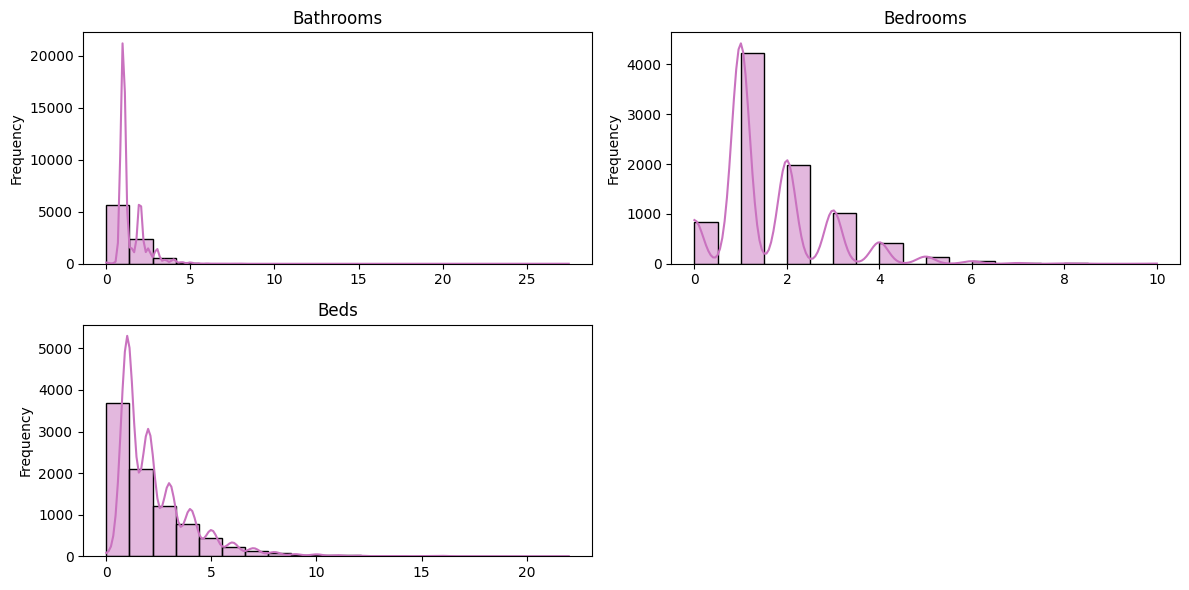

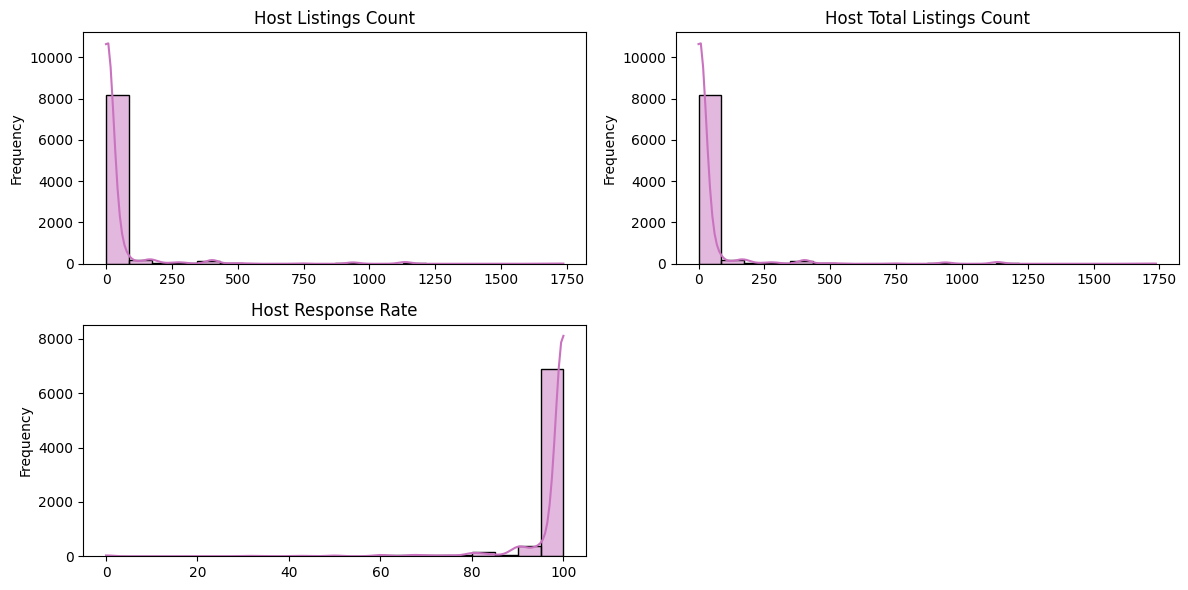

In [ ]:
# 1- Mode filling for categorical columns
mode_fill_columns = [
    'market', 'host_neighbourhood', 'state', 'neighbourhood',
    'host_location', 'host_response_time', 'zipcode',
    'host_since', 'host_is_superhost', 'host_has_profile_pic',
    'host_identity_verified', 'host_name'
]

for col in mode_fill_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# 2- Median filling for numerical columns
# (removed 'host_rating' because it's not in the dataset)
median_fill_columns = [
    'bathrooms', 'bedrooms', 'beds',
    'host_listings_count', 'host_total_listings_count',
    'host_response_rate'
]

# Visualize distributions (optional)
import math
import seaborn as sns
import matplotlib.pyplot as plt

half = math.ceil(len(median_fill_columns) / 2)
columns_split = [median_fill_columns[:half], median_fill_columns[half:]]

for group in columns_split:
    fig, axes = plt.subplots(-(-len(group) // 2), 2, figsize=(12, len(group) * 2))
    axes = axes.flatten()

    for ax, col in zip(axes, group):
        sns.histplot(df[col], kde=True, color="#C972BF", edgecolor='black', bins=20, ax=ax)
        ax.set_title(col.replace("_", " ").title())
        ax.set_xlabel('')
        ax.set_ylabel('Frequency')

    for ax in axes[len(group):]:
        ax.remove()

    plt.tight_layout()
    plt.show()

# Fill missing values with median
for col in median_fill_columns:
    df[col].fillna(df[col].median(), inplace=True)


 Handling nulls by filling it with zero

#NOTE:For `security_deposit` and `cleaning_fee`, filling with `0` made sense logically, as the absence of a value likely indicates no fee was required.  
#while acknowledging that the actual data is unavailable.



In [ ]:
df['security_deposit'].fillna(0,inplace=True)
df['cleaning_fee'].fillna(0,inplace=True)

Handling nulls in text columns

Filling with Default Phrases

#NOTE: For other text fields such as `neighborhood_overview`, `notes`, `transit`, `access`, `interaction`, `house_rules`, and `host_about`,
#we filled missing values with default placeholders like `"No neighborhood info"` or `"No house rules"`.  
#These placeholders indicate missing data without introducing misleading or artificial content, while still maintaining data consistency and structure.
Filling with Default Phrases

#NOTE: For other text fields such as `neighborhood_overview`, `notes`, `transit`, `access`, `interaction`, `house_rules`, and `host_about`,
#we filled missing values with default placeholders like `"No neighborhood info"` or `"No house rules"`.  
#These placeholders indicate missing data without introducing misleading or artificial content, while still maintaining data consistency and structure.


In [ ]:
df['neighborhood_overview'].fillna("No neighborhood info", inplace=True)
df['notes'].fillna("No notes", inplace=True)
df['transit'].fillna("No transit info", inplace=True)
df['access'].fillna("No access info", inplace=True)
df['interaction'].fillna("No interaction info", inplace=True)
df['house_rules'].fillna("No house rules", inplace=True)
df['host_about'].fillna("No host info", inplace=True)

Text Generation using Cohere API

#NOTE:For key descriptive fields like `space`, `description`, and `summary`,
#we used Cohere's language generation capabilities to generate meaningful replacements.
#This helped preserve the quality and completeness of listings where descriptive content is important.

In [ ]:
print("Nulls after handling:\n",df.isnull().sum())

Nulls after handling:
 id                                     0
listing_url                            0
name                                   0
summary                              227
space                               1619
description                           94
neighborhood_overview                  0
notes                                  0
transit                                0
access                                 0
interaction                            0
house_rules                            0
thumbnail_url                       8724
host_id                                0
host_url                               0
host_name                              0
host_since                             0
host_location                          0
host_about                             0
host_response_time                     0
host_response_rate                     0
host_acceptance_rate                8724
host_is_superhost                      0
host_neighbourhood                

region Flooring Columns
#NOTE:For the numeric columns `bathrooms`, `bedrooms`, and `beds`,
#we applied a floor operation to round down the values as fractional values for those columns don't have meaningful interpretations.


In [ ]:
numeric_columns = ['bathrooms', 'bedrooms', 'beds']

for col in numeric_columns:
    df[col] = np.floor(df[col]).astype(int)

Text Processing

Text Cleaning

In [ ]:
print("BEFORE CLEANING:",df['summary'].iloc[8722])

BEFORE CLEANING: Luxury single family home near I-5 Freeway and Highway 52, just 2 miles east of La Jolla Shores Beach, shops, restaurants, 2 miles north of Pacific Beach, easy access to all by car. HVAC, solar powered pool, basketball net, gas fire pit for cozy conversations and your own private bedroom.


In [ ]:
text_columns = ['summary', 'space', 'description','notes', 'transit', 'access', 'house_rules']
for col in text_columns:
    df[col] = (
        df[col]
        .str.lower() # lowercasing
        .str.replace(r"http\S+|www\S+|[\w\.-]+@[\w\.-]+", "", regex=True)  # remove URLs & emails
        .str.replace(r"<.*?>", "", regex=True)  # remove HTML tags
        .str.replace(r"[^a-zA-Z0-9\s]", "", regex=True)  # remove punctuation & special chars
        .str.replace(r"\s+", " ", regex=True)  # collapse multiple spaces
        .str.strip()  # trim leading/trailing spaces
    )

In [ ]:
print("AFTER CLEANING:",df['summary'].iloc[8722])

AFTER CLEANING: luxury single family home near i5 freeway and highway 52 just 2 miles east of la jolla shores beach shops restaurants 2 miles north of pacific beach easy access to all by car hvac solar powered pool basketball net gas fire pit for cozy conversations and your own private bedroom


 Handling Contractions


In [ ]:
contractions_dict = {
    "isn’t": " is not",
    "don’t": " do not",
    "aren’t": " are not",
    "can’t": " cannot",
    "couldn’t": " could not",
    "didn’t": " did not",
    "’ve": " have",
    "’d": " would",
    "u": " you",
    "’m": " am",
    "’ll":" will",
    "’re": " are",
    "won’t": " will not"

}
def expand_contractions(text):
    if isinstance(text, str):
        for contraction, expansion in contractions_dict.items():
            text = re.sub(r'\b' + re.escape(contraction) + r'\b', expansion, text)
    return text

for col in text_columns:
    df[col] = df[col].apply(expand_contractions)

print("AFTER EXPANDING CONTRADICTIONS:",df['summary'].iloc[8722])

AFTER EXPANDING CONTRADICTIONS: luxury single family home near i5 freeway and highway 52 just 2 miles east of la jolla shores beach shops restaurants 2 miles north of pacific beach easy access to all by car hvac solar powered pool basketball net gas fire pit for cozy conversations and your own private bedroom


Tokenization

In [ ]:
import nltk

nltk.download('punkt')                # tokenize
nltk.download('stopwords')           # stopwords
nltk.download('wordnet')             # WordNetLemmatizer
nltk.download('omw-1.4')             # دعم إضافي للغات wordnet
print(f"done")


[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


done


[nltk_data] Error loading omw-1.4: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

print("Ready ✅")

Ready ✅


In [ ]:
from nltk.tokenize import word_tokenize

for col in text_columns:
    df[col] = df[col].apply(lambda x: word_tokenize(str(x)))
    print(f"✅ Tokenization done for column: {col}")


✅ Tokenization done for column: summary
✅ Tokenization done for column: space
✅ Tokenization done for column: description
✅ Tokenization done for column: notes
✅ Tokenization done for column: transit
✅ Tokenization done for column: access
✅ Tokenization done for column: house_rules


Removing Stop words

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stop_words(tokens):
    return [word for word in tokens if word not in stop_words]

for col in text_columns:
    df[col] = df[col].apply(remove_stop_words)
    print(f"✅ Stopwords removed from column: {col}")


✅ Stopwords removed from column: summary
✅ Stopwords removed from column: space
✅ Stopwords removed from column: description
✅ Stopwords removed from column: notes
✅ Stopwords removed from column: transit
✅ Stopwords removed from column: access
✅ Stopwords removed from column: house_rules


In [ ]:
print(df[text_columns[0]].head(3))


0    [beautiful, 2, bedroom, 2, bathroom, furnished...
1    [feel, house, great, place, family, relax, unw...
2    [zen, luxury, best, location, americas, finest...
Name: summary, dtype: object


 Lemmatization

In [ ]:
from nltk.stem import WordNetLemmatizer
print("BEFORE LEMMATIZATION:",df.iloc[:5,5].to_frame())
lemmatizer = WordNetLemmatizer()

def lemma(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]


for col in text_columns:
    df[col] = df[col].apply(lemma)
print("AFTER LEMMATIZATION:",df.iloc[:5,3].to_frame())

BEFORE LEMMATIZATION:                                          description
0  [beautiful, 2, bedroom, 2, bathroom, furnished...
1  [feel, house, great, place, family, relax, unw...
2  [zen, luxury, best, location, americas, finest...
3  [start, day, breakfast, sunny, patio, overlook...
4  [2, bedroom1, bathroom, beachside, unit, locat...
AFTER LEMMATIZATION:                                              summary
0  [beautiful, 2, bedroom, 2, bathroom, furnished...
1  [feel, house, great, place, family, relax, unw...
2  [zen, luxury, best, location, america, finest,...
3  [start, day, breakfast, sunny, patio, overlook...
4  [2, bedroom1, bathroom, beachside, unit, locat...


 Text Vectorization using Tf_Idf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

df['summary'] = df['summary'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
df['space'] = df['space'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
df['description'] = df['description'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
df['notes'] = df['notes'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
df['transit'] = df['transit'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
df['access'] = df['access'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
df['house_rules'] = df['house_rules'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)


In [ ]:
# summary
summary_tfidf = TfidfVectorizer(max_features=1000)
summary_features = summary_tfidf.fit_transform(df['summary'])
summary_tfidf_df = pd.DataFrame(summary_features.toarray(), columns=[f"summary_{f}" for f in summary_tfidf.get_feature_names_out()])


In [ ]:
# space
space_tfidf = TfidfVectorizer(max_features=1000)
space_features = space_tfidf.fit_transform(df['space'])
space_tfidf_df = pd.DataFrame(space_features.toarray(), columns=[f"space_{f}" for f in space_tfidf.get_feature_names_out()])


In [ ]:
# description
description_tfidf = TfidfVectorizer(max_features=1000)
description_features = description_tfidf.fit_transform(df['description'])
description_tfidf_df = pd.DataFrame(description_features.toarray(), columns=[f"description_{f}" for f in description_tfidf.get_feature_names_out()])


In [ ]:
# notes
notes_tfidf = TfidfVectorizer(max_features=1000)
notes_features = notes_tfidf.fit_transform(df['notes'])
notes_tfidf_df = pd.DataFrame(notes_features.toarray(), columns=[f"notes_{f}" for f in notes_tfidf.get_feature_names_out()])


In [ ]:
# transit
transit_tfidf = TfidfVectorizer(max_features=1000)
transit_features = transit_tfidf.fit_transform(df['transit'])
transit_tfidf_df = pd.DataFrame(transit_features.toarray(), columns=[f"transit_{f}" for f in transit_tfidf.get_feature_names_out()])


In [ ]:
# access
access_tfidf = TfidfVectorizer(max_features=1000)
access_features = access_tfidf.fit_transform(df['access'])
access_tfidf_df = pd.DataFrame(access_features.toarray(), columns=[f"access_{f}" for f in access_tfidf.get_feature_names_out()])


In [ ]:
# house_rules
house_rules_tfidf = TfidfVectorizer(max_features=1000)
house_rules_features = house_rules_tfidf.fit_transform(df['house_rules'])
house_rules_tfidf_df = pd.DataFrame(house_rules_features.toarray(), columns=[f"house_rules_{f}" for f in house_rules_tfidf.get_feature_names_out()])


Dimensionality Reduction using SVD

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd_summary = TruncatedSVD(n_components=35, random_state=0)
svd_space = TruncatedSVD(n_components=35, random_state=0)
svd_transit = TruncatedSVD(n_components=35, random_state=0)
svd_access = TruncatedSVD(n_components=35, random_state=0)
svd_description = TruncatedSVD(n_components=35, random_state=0)
svd_notes = TruncatedSVD(n_components=35, random_state=0)
svd_house_rules = TruncatedSVD(n_components=35, random_state=0)

summary_svd_df = pd.DataFrame(svd_summary.fit_transform(summary_features), columns=[f"summary_svd_{i}" for i in range(35)])
space_svd_df = pd.DataFrame(svd_space.fit_transform(space_features), columns=[f"space_svd_{i}" for i in range(35)])
transit_svd_df = pd.DataFrame(svd_transit.fit_transform(transit_features), columns=[f"transit_svd_{i}" for i in range(35)])
access_svd_df = pd.DataFrame(svd_access.fit_transform(access_features), columns=[f"access_svd_{i}" for i in range(35)])
description_svd_df = pd.DataFrame(svd_description.fit_transform(description_features), columns=[f"description_svd_{i}" for i in range(35)])
notes_svd_df = pd.DataFrame(svd_notes.fit_transform(notes_features), columns=[f"notes_svd_{i}" for i in range(35)])
house_rules_svd_df = pd.DataFrame(svd_house_rules.fit_transform(house_rules_features), columns=[f"house_rules_svd_{i}" for i in range(35)])



In [ ]:
df.reset_index(drop=True, inplace=True)
df = pd.concat([
    df,
    summary_svd_df,
    space_svd_df,
    transit_svd_df,
    access_svd_df,
    description_svd_df,
    notes_svd_df,
    house_rules_svd_df
], axis=1)

Sentiment Analysis

Calculating sentiment score using TextBlob

In [ ]:
from textblob import TextBlob
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

for column in ['interaction',  'host_about','neighborhood_overview','name']:
    df[column] = df[column].apply(get_sentiment)

print(df[['interaction','host_about','neighborhood_overview']].head(5))


   interaction  host_about  neighborhood_overview
0       0.0700    0.000000               0.000000
1       0.1375    0.250000               0.163333
2       0.5000    0.341473               0.308102
3       0.4000    0.000000               0.290625
4      -0.0500    0.175000               0.148760


Standardize Short Text Columns

In [ ]:
columns_to_standardize = [
    'host_name', 'host_location', 'host_neighbourhood',
    'street', 'neighbourhood', 'neighbourhood_cleansed',
    'city', 'state', 'market', 'smart_location', 'country_code','country','property_type','room_type'
]
for col in columns_to_standardize:
    df[col] = df[col].str.lower().str.strip()

Encoding

1-Label Encoder

In [ ]:
label_encoders = {}

columns_to_encode = [
    'host_neighbourhood', 'street', 'neighbourhood', 'neighbourhood_cleansed',
    'city', 'state', 'market', 'smart_location', 'country_code', 'country',
    'property_type', 'room_type', 'host_name'
]

for col in columns_to_encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

Binary Mapping of Boolean Columns

In [ ]:
columns_to_map = [
    'host_has_profile_pic', 'host_identity_verified', 'is_location_exact',
    'requires_license', 'instant_bookable', 'is_business_travel_ready',
    'require_guest_phone_verification', 'host_is_superhost'
]
mapping_dict = {'t': 1, 'f': 0}
for col in columns_to_map:
    df[col] = df[col].map(mapping_dict)


#NOTE:the `require_guest_profile_picture` column is transformed by reversing the typical boolean mapping, where `'t'` (true) is mapped to `0` and `'f'` (false) is mapped to `1`.
# This reversed mapping was chosen because we found it better not to ask for a guest profile picture


In [ ]:
df['require_guest_profile_picture'] = df['require_guest_profile_picture'].map({'t': 0, 'f': 1})


Mapping Categorical Data to Numeric Values with Rank (Higher is Better)

In [ ]:
response_mapping = {
    'within an hour': 3,
    'within a few hours': 2,
    'within a day': 1,
    'a few days or more': 0
}
df['host_response_time'] = df['host_response_time'].map(response_mapping)

In [ ]:
bed_rank = {
    'Airbed': 0,
    'Couch': 1,
    'Futon': 2,
    'Pull-out Sofa': 3,
    'Real Bed': 4
}

df['bed_type'] = df['bed_type'].map(bed_rank)


In [ ]:
cancellation_rank = {
    'flexible': 5,
    'moderate': 4,
    'strict': 3,
    'strict_14_with_grace_period': 2,
    'super_strict_30': 1,
    'super_strict_60': 0
}

df['cancellation_policy'] = df['cancellation_policy'].map(cancellation_rank)

Check outliers

id: عدد الـ outliers = 0


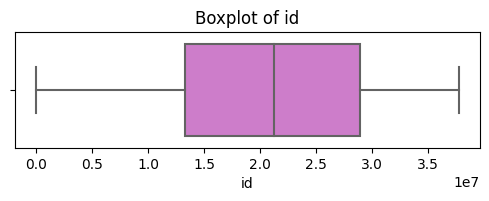

name: عدد الـ outliers = 760


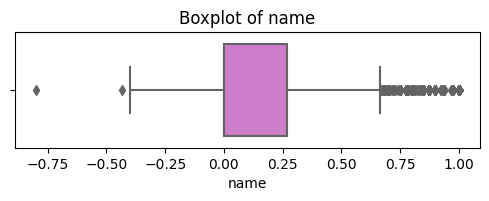

neighborhood_overview: عدد الـ outliers = 131


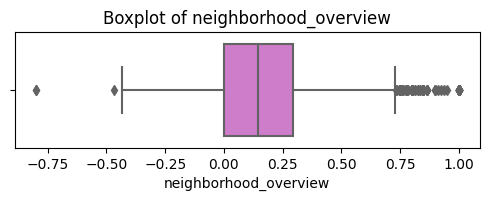

interaction: عدد الـ outliers = 0


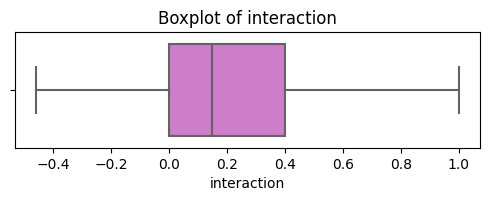

thumbnail_url: عدد الـ outliers = 0


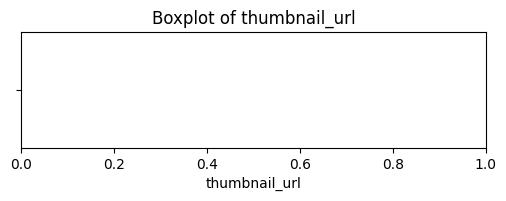

host_id: عدد الـ outliers = 80


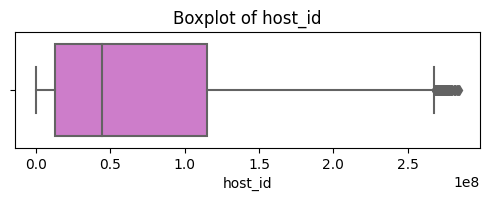

host_name: عدد الـ outliers = 0


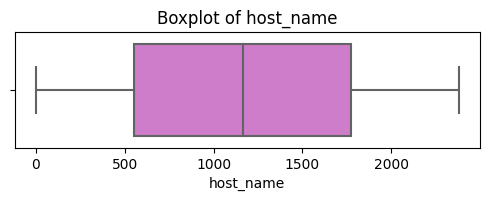

host_about: عدد الـ outliers = 28


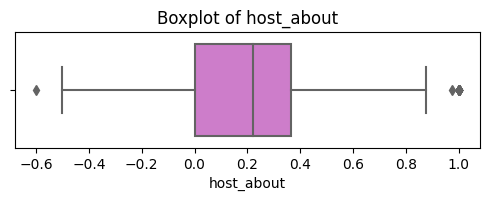

host_response_time: عدد الـ outliers = 1554


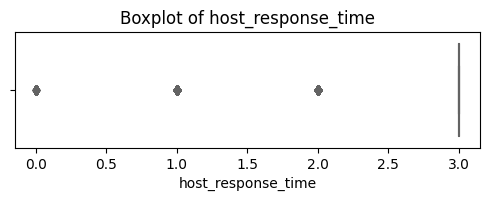

host_response_rate: عدد الـ outliers = 1700


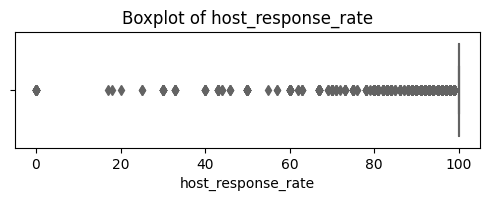

host_acceptance_rate: عدد الـ outliers = 0


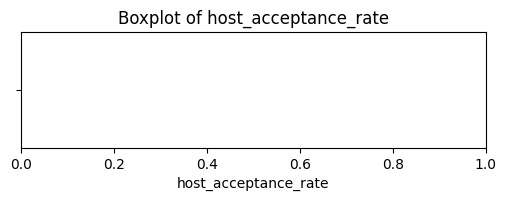

host_is_superhost: عدد الـ outliers = 0


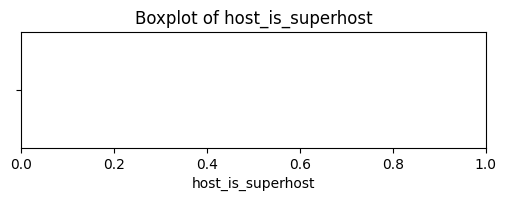

host_neighbourhood: عدد الـ outliers = 0


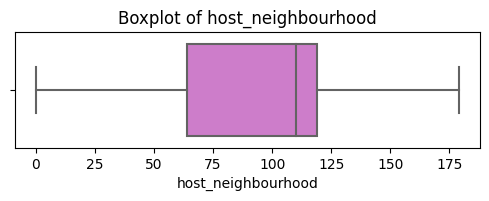

host_listings_count: عدد الـ outliers = 1301


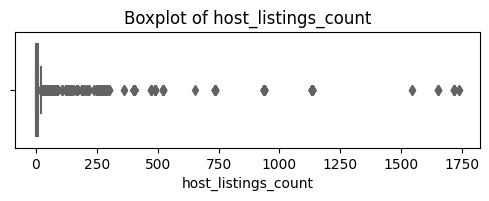

host_total_listings_count: عدد الـ outliers = 1301


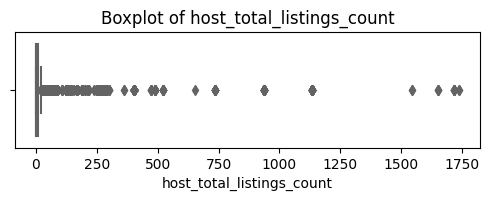

host_has_profile_pic: عدد الـ outliers = 0


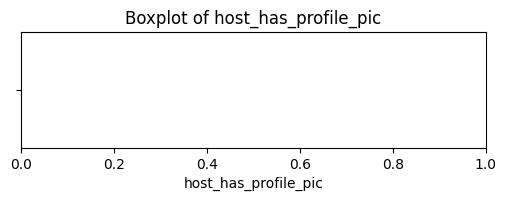

host_identity_verified: عدد الـ outliers = 0


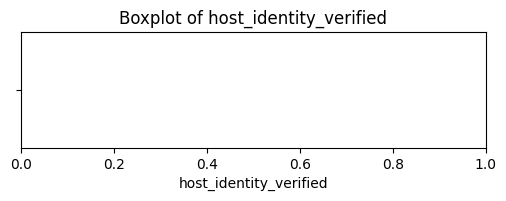

street: عدد الـ outliers = 512


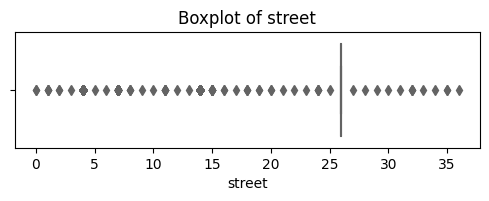

neighbourhood: عدد الـ outliers = 0


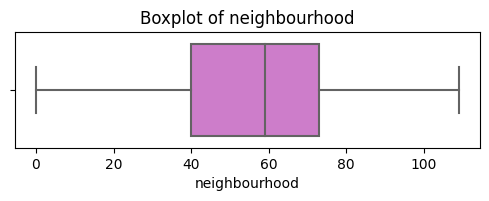

neighbourhood_cleansed: عدد الـ outliers = 0


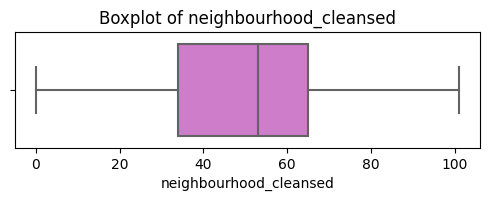

city: عدد الـ outliers = 506


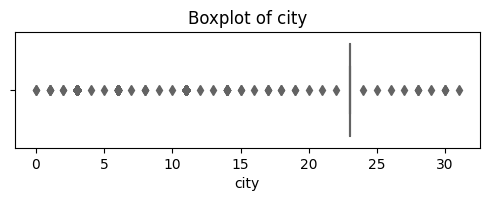

state: عدد الـ outliers = 6


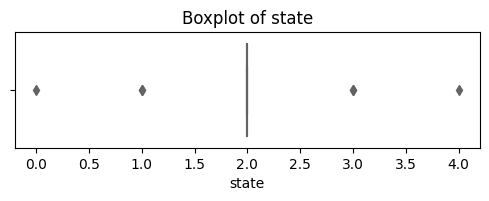

zipcode: عدد الـ outliers = 1456


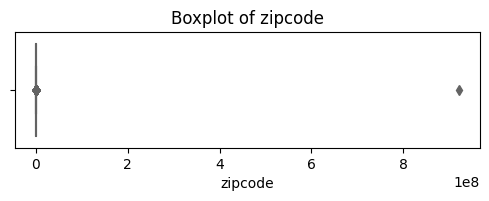

market: عدد الـ outliers = 29


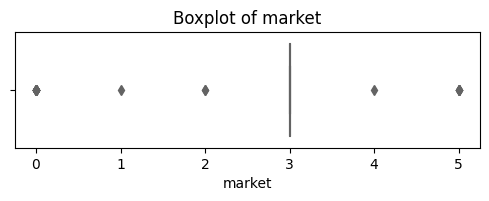

smart_location: عدد الـ outliers = 512


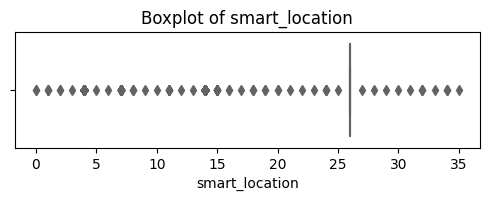

country_code: عدد الـ outliers = 4


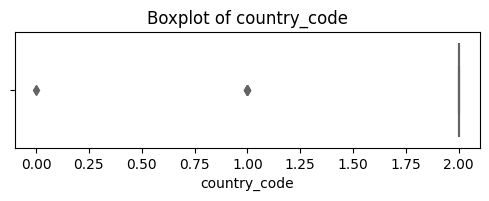

country: عدد الـ outliers = 4


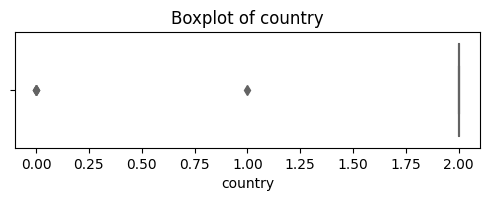

latitude: عدد الـ outliers = 521


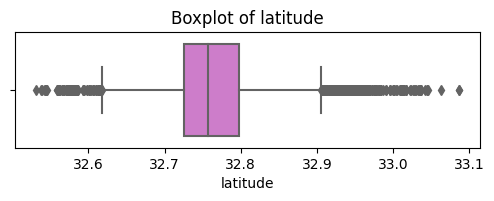

longitude: عدد الـ outliers = 46


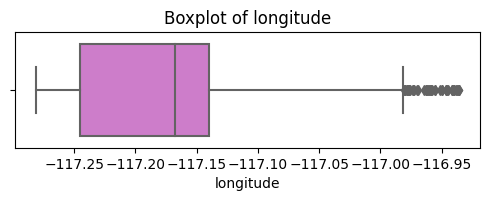

is_location_exact: عدد الـ outliers = 0


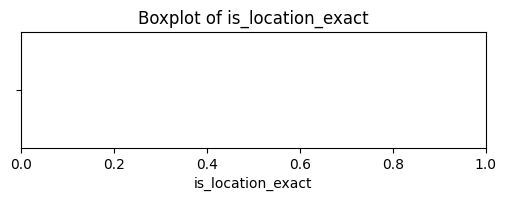

property_type: عدد الـ outliers = 0


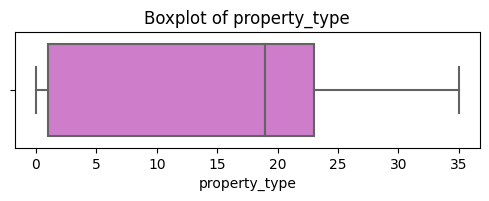

room_type: عدد الـ outliers = 0


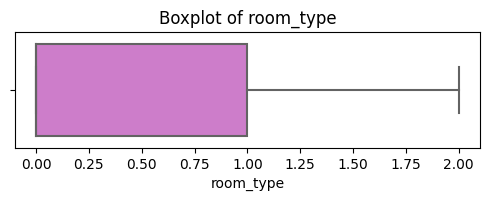

accommodates: عدد الـ outliers = 179


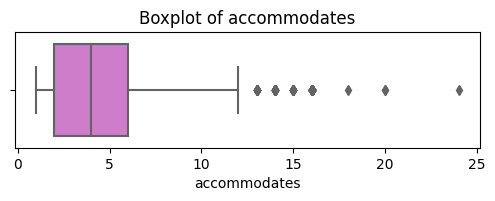

bathrooms: عدد الـ outliers = 219


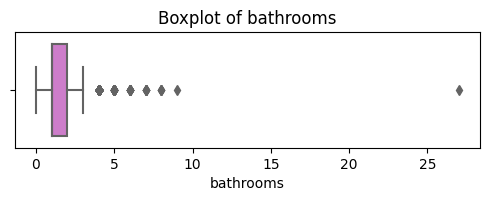

bedrooms: عدد الـ outliers = 627


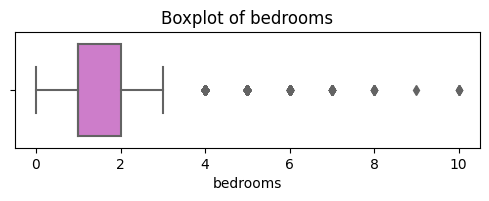

beds: عدد الـ outliers = 317


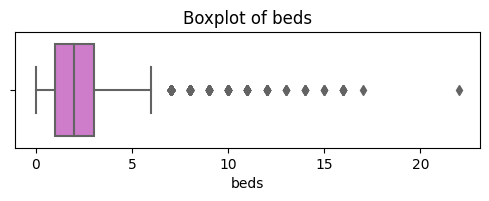

bed_type: عدد الـ outliers = 70


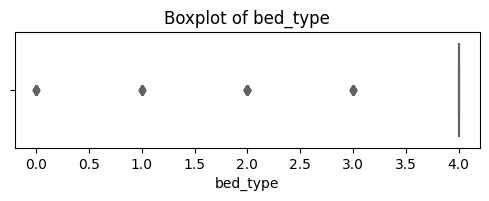

square_feet: عدد الـ outliers = 5


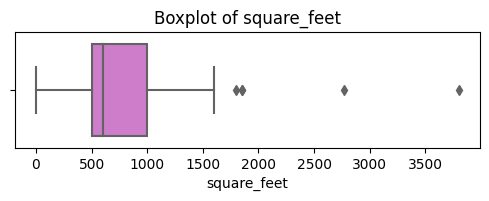

nightly_price: عدد الـ outliers = 687


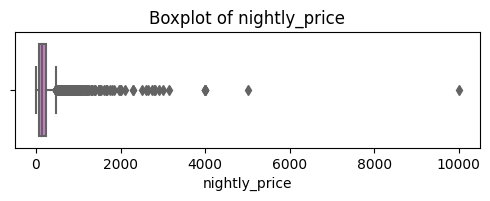

price_per_stay: عدد الـ outliers = 653


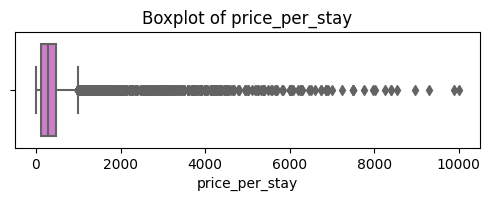

security_deposit: عدد الـ outliers = 211


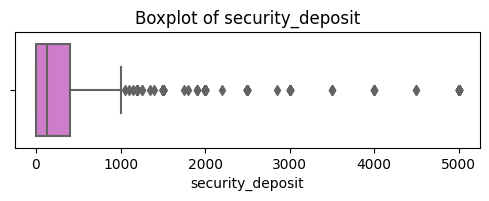

cleaning_fee: عدد الـ outliers = 512


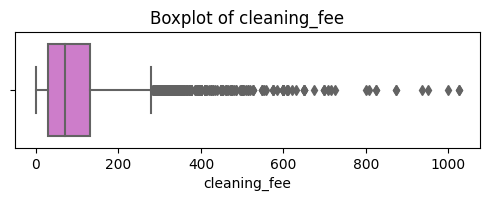

guests_included: عدد الـ outliers = 504


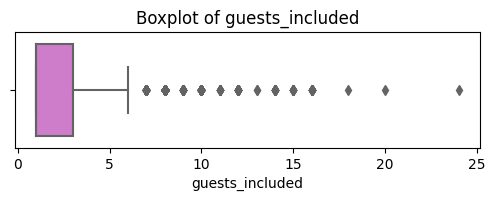

extra_people: عدد الـ outliers = 318


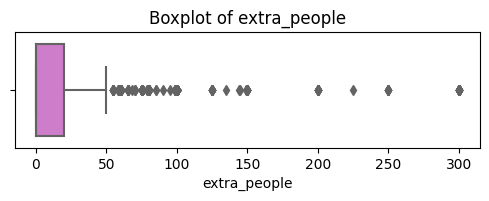

minimum_nights: عدد الـ outliers = 629


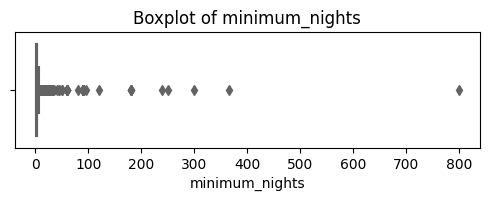

maximum_nights: عدد الـ outliers = 4


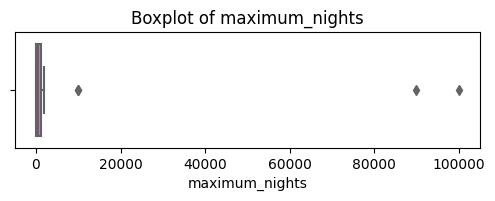

number_of_reviews: عدد الـ outliers = 755


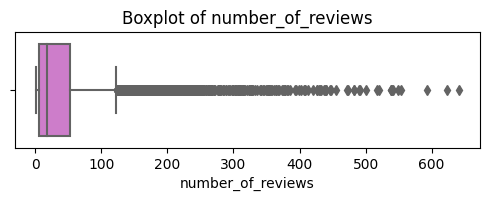

number_of_stays: عدد الـ outliers = 755


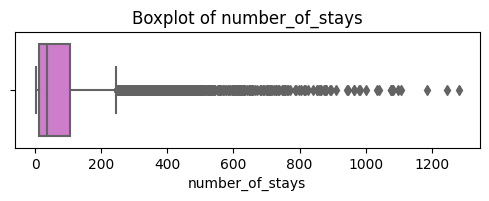

review_scores_rating: عدد الـ outliers = 475


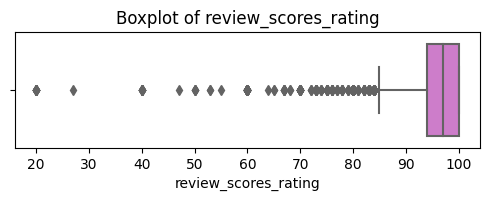

requires_license: عدد الـ outliers = 0


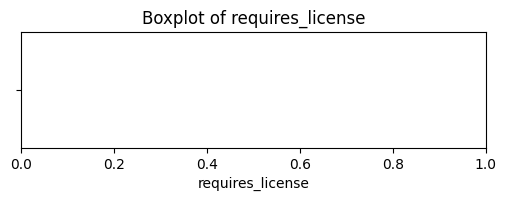

instant_bookable: عدد الـ outliers = 0


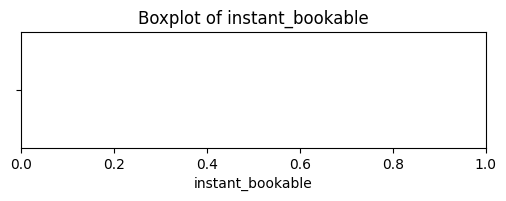

is_business_travel_ready: عدد الـ outliers = 0


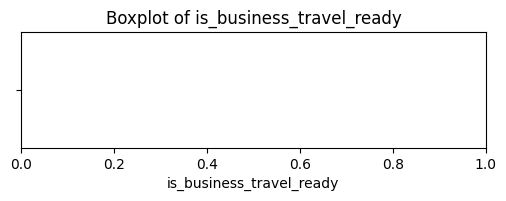

cancellation_policy: عدد الـ outliers = 0


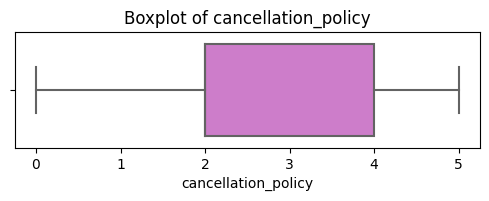

require_guest_profile_picture: عدد الـ outliers = 241


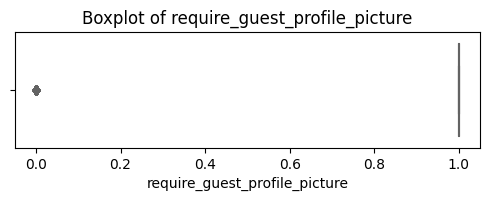

require_guest_phone_verification: عدد الـ outliers = 0


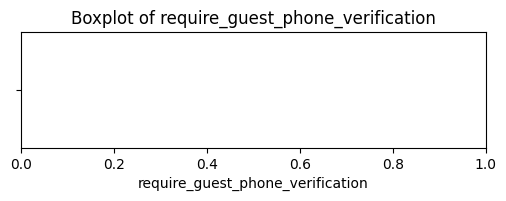

summary_svd_0: عدد الـ outliers = 266


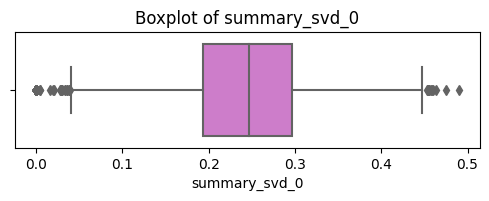

summary_svd_1: عدد الـ outliers = 326


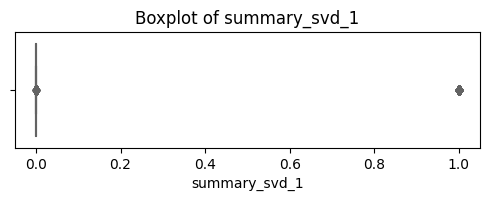

summary_svd_2: عدد الـ outliers = 40


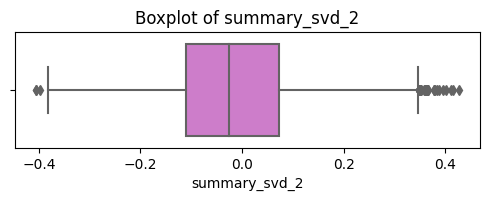

summary_svd_3: عدد الـ outliers = 248


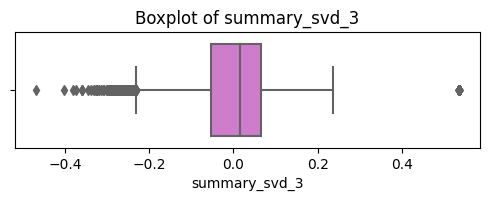

summary_svd_4: عدد الـ outliers = 385


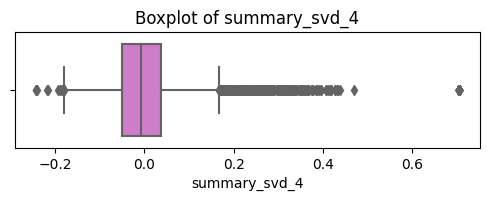

summary_svd_5: عدد الـ outliers = 556


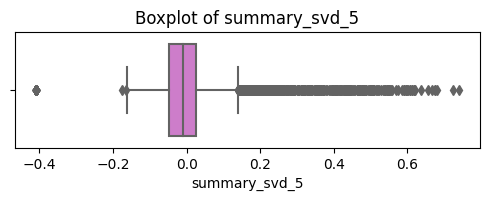

summary_svd_6: عدد الـ outliers = 183


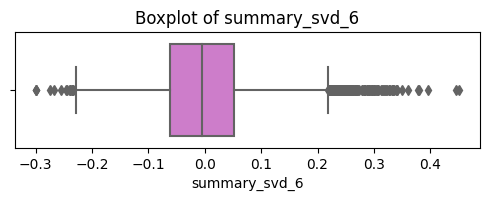

summary_svd_7: عدد الـ outliers = 64


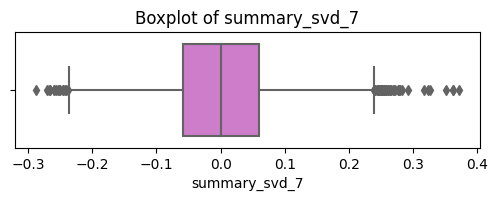

summary_svd_8: عدد الـ outliers = 412


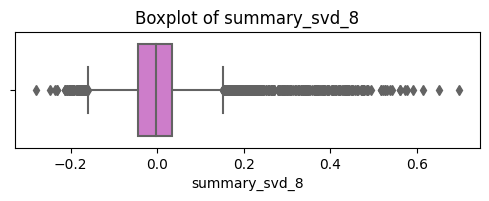

summary_svd_9: عدد الـ outliers = 141


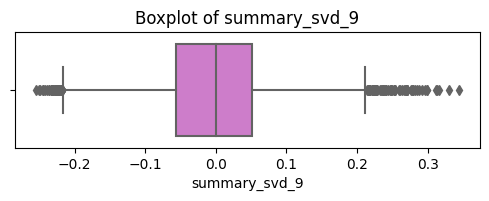

summary_svd_10: عدد الـ outliers = 144


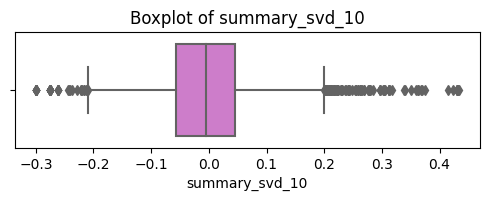

summary_svd_11: عدد الـ outliers = 362


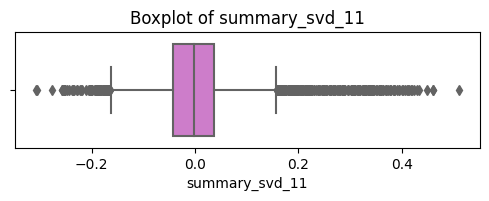

summary_svd_12: عدد الـ outliers = 450


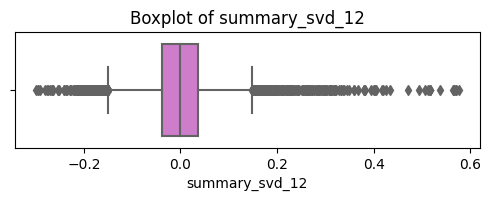

summary_svd_13: عدد الـ outliers = 304


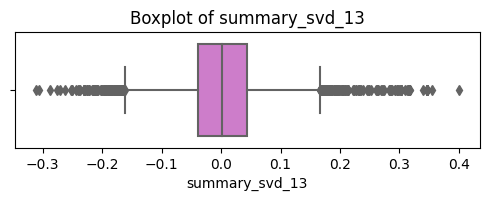

summary_svd_14: عدد الـ outliers = 194


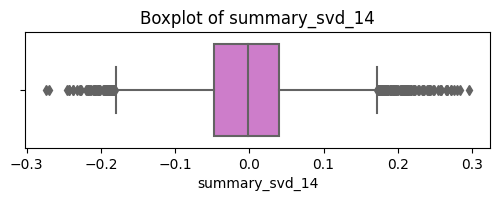

summary_svd_15: عدد الـ outliers = 162


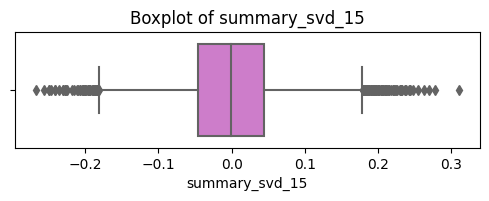

summary_svd_16: عدد الـ outliers = 162


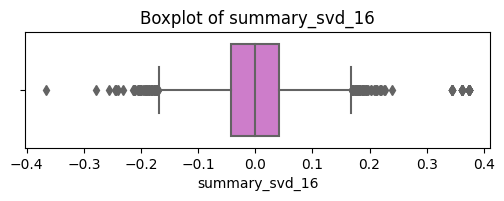

summary_svd_17: عدد الـ outliers = 185


summary_svd_18: عدد الـ outliers = 257


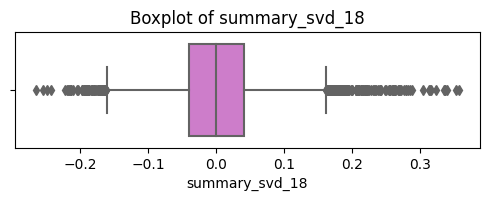

summary_svd_19: عدد الـ outliers = 211


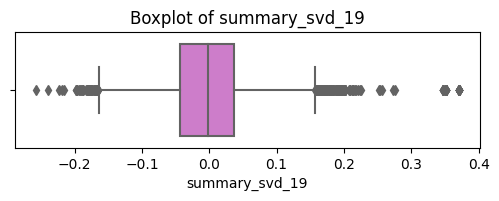

summary_svd_20: عدد الـ outliers = 157


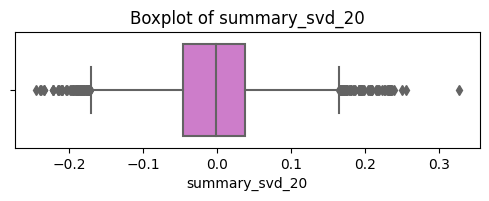

summary_svd_21: عدد الـ outliers = 210


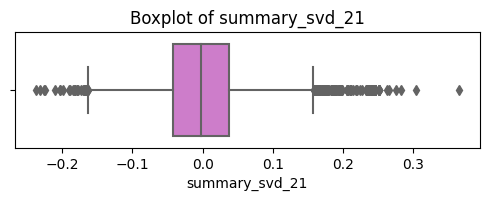

summary_svd_22: عدد الـ outliers = 133


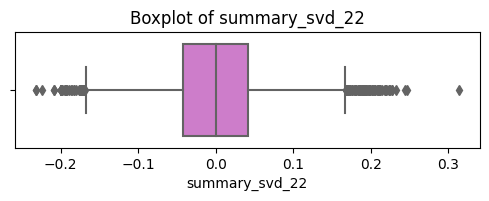

summary_svd_23: عدد الـ outliers = 132


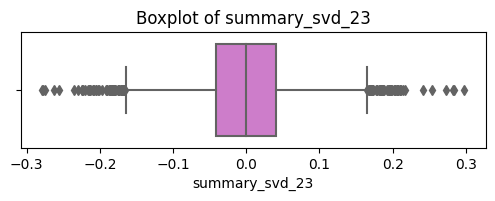

summary_svd_24: عدد الـ outliers = 261


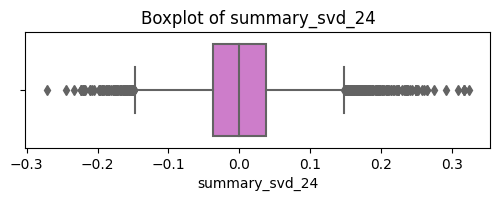

summary_svd_25: عدد الـ outliers = 202


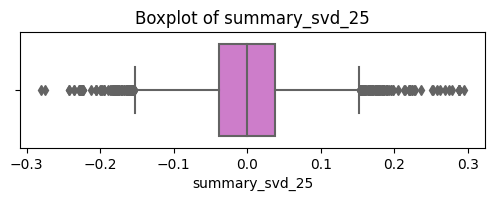

summary_svd_26: عدد الـ outliers = 218


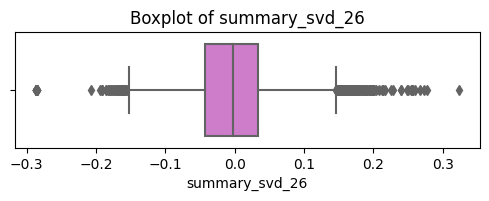

summary_svd_27: عدد الـ outliers = 228


summary_svd_28: عدد الـ outliers = 238


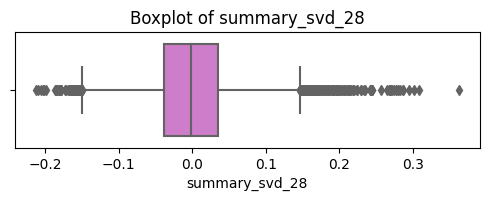

summary_svd_29: عدد الـ outliers = 172


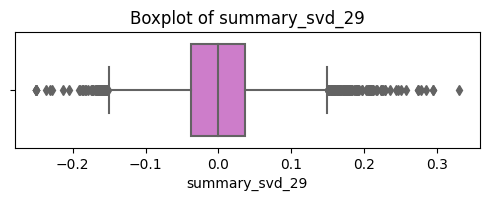

summary_svd_30: عدد الـ outliers = 114


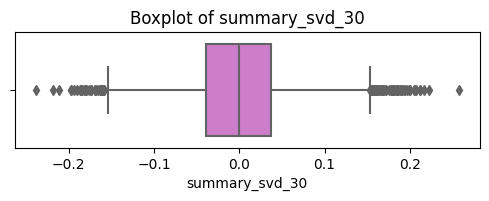

summary_svd_31: عدد الـ outliers = 153


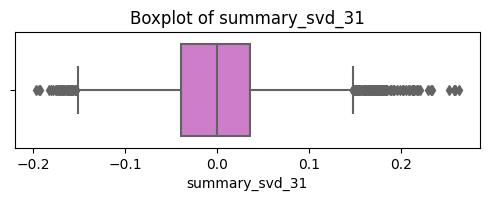

summary_svd_32: عدد الـ outliers = 160


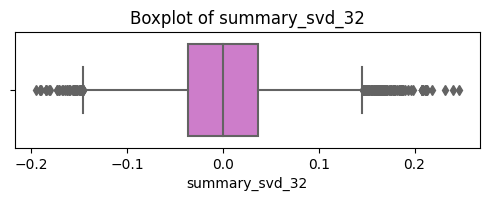

summary_svd_33: عدد الـ outliers = 178


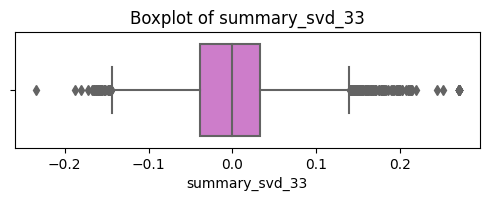

summary_svd_34: عدد الـ outliers = 180


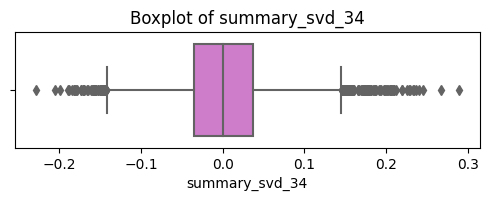

space_svd_0: عدد الـ outliers = 1624


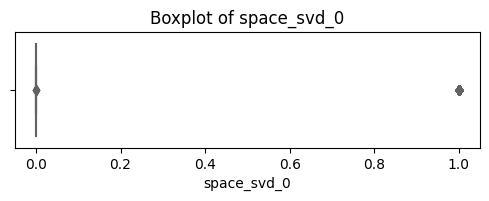

space_svd_1: عدد الـ outliers = 0


space_svd_2: عدد الـ outliers = 566


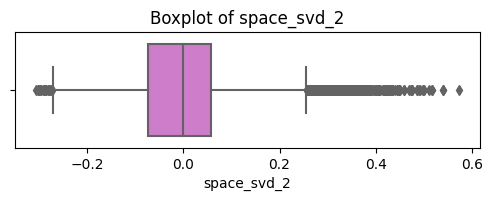

space_svd_3: عدد الـ outliers = 604


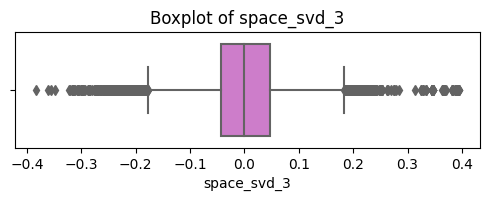

space_svd_4: عدد الـ outliers = 488


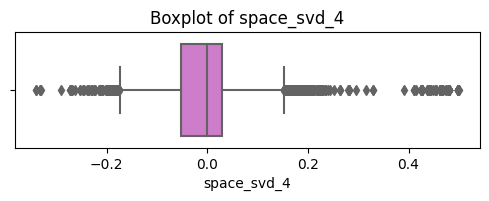

space_svd_5: عدد الـ outliers = 376


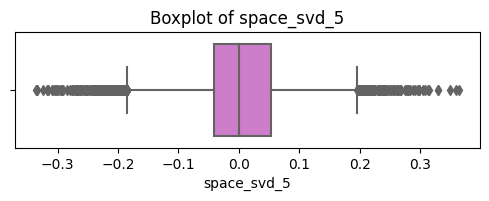

space_svd_6: عدد الـ outliers = 528


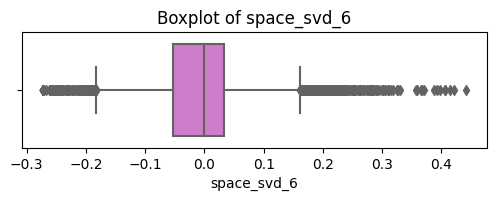

space_svd_7: عدد الـ outliers = 293


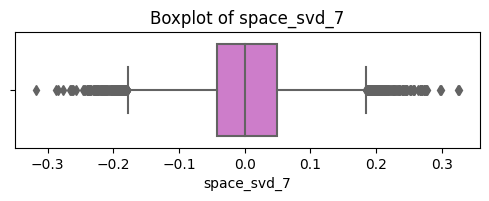

space_svd_8: عدد الـ outliers = 331


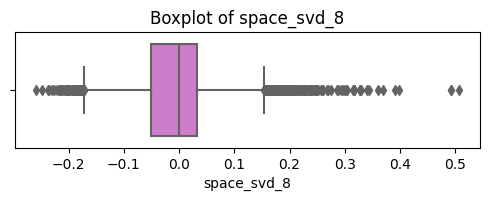

space_svd_9: عدد الـ outliers = 350


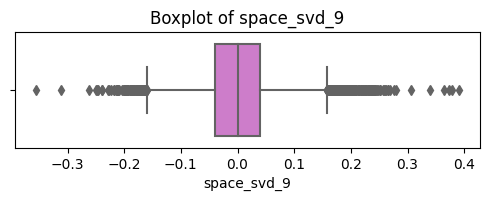

space_svd_10: عدد الـ outliers = 591


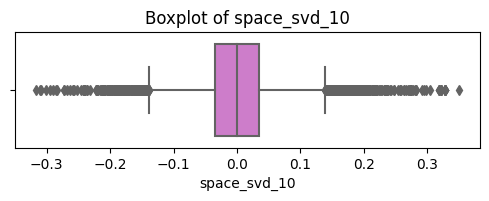

space_svd_11: عدد الـ outliers = 471


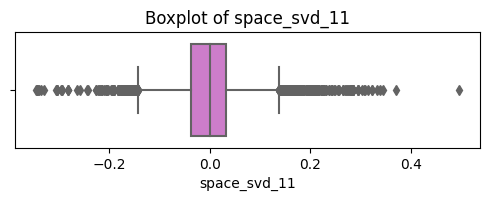

space_svd_12: عدد الـ outliers = 551


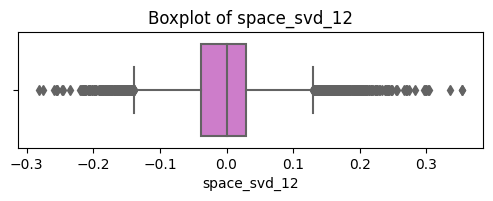

space_svd_13: عدد الـ outliers = 405


space_svd_14: عدد الـ outliers = 342


space_svd_15: عدد الـ outliers = 381


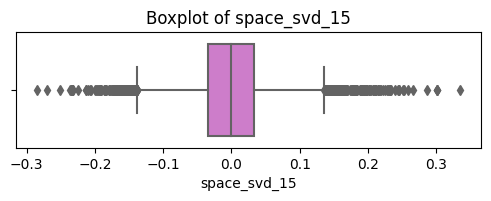

space_svd_16: عدد الـ outliers = 569


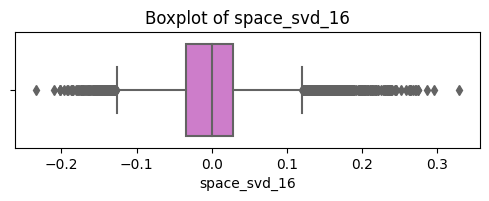

space_svd_17: عدد الـ outliers = 501


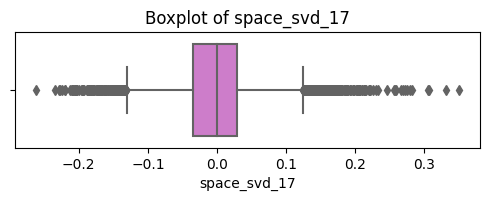

space_svd_18: عدد الـ outliers = 532


space_svd_19: عدد الـ outliers = 497


space_svd_20: عدد الـ outliers = 455


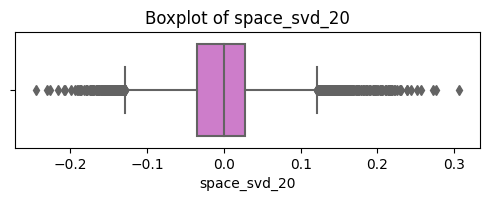

space_svd_21: عدد الـ outliers = 536


space_svd_22: عدد الـ outliers = 512


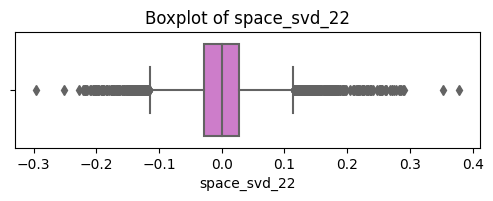

space_svd_23: عدد الـ outliers = 403


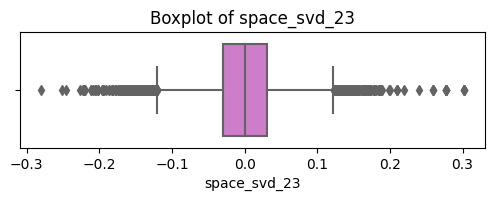

space_svd_24: عدد الـ outliers = 451


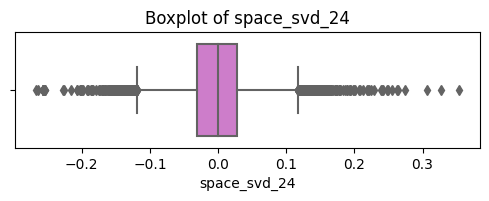

space_svd_25: عدد الـ outliers = 457


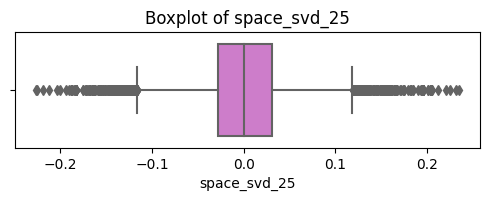

space_svd_26: عدد الـ outliers = 402


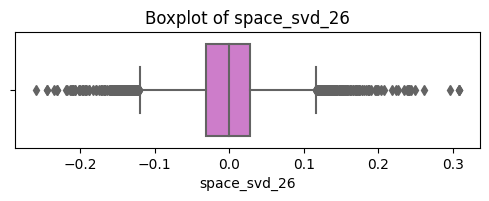

space_svd_27: عدد الـ outliers = 393


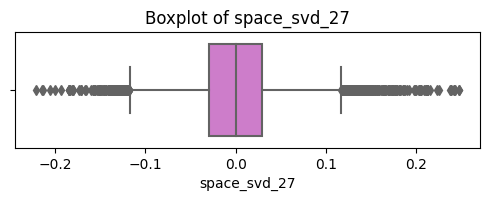

space_svd_28: عدد الـ outliers = 396


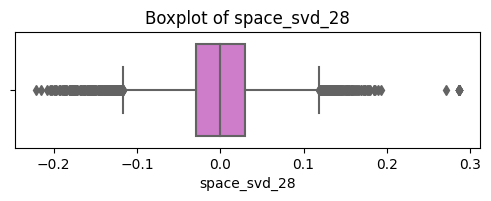

space_svd_29: عدد الـ outliers = 485


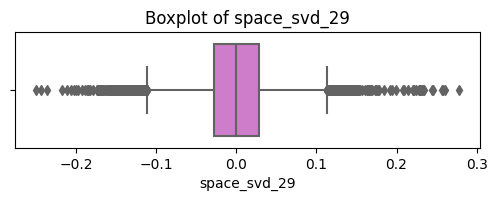

space_svd_30: عدد الـ outliers = 456


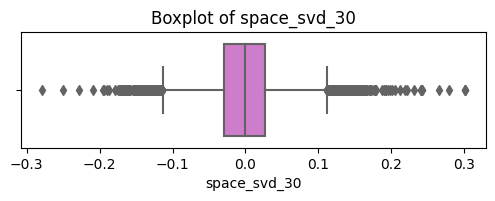

space_svd_31: عدد الـ outliers = 368


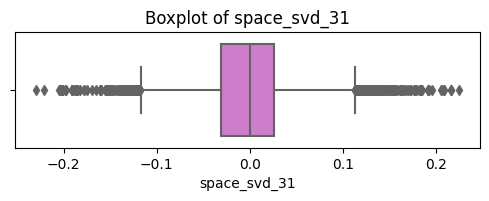

space_svd_32: عدد الـ outliers = 441


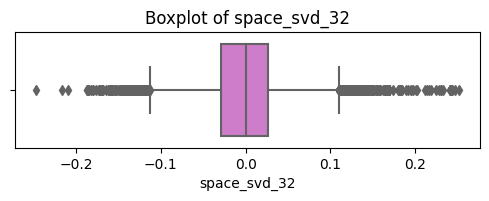

space_svd_33: عدد الـ outliers = 371


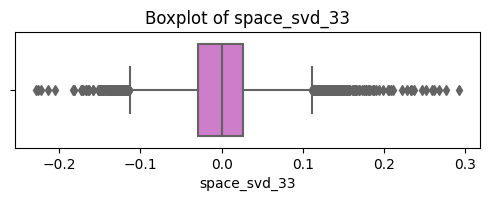

space_svd_34: عدد الـ outliers = 431


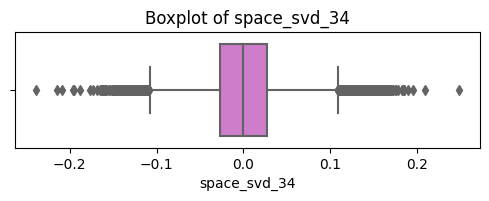

transit_svd_0: عدد الـ outliers = 0


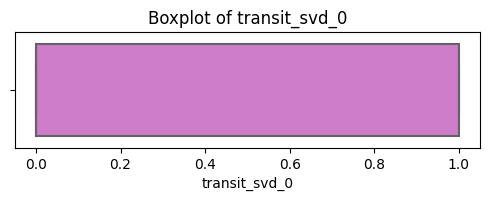

transit_svd_1: عدد الـ outliers = 0


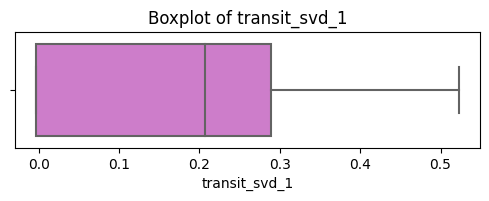

transit_svd_2: عدد الـ outliers = 941


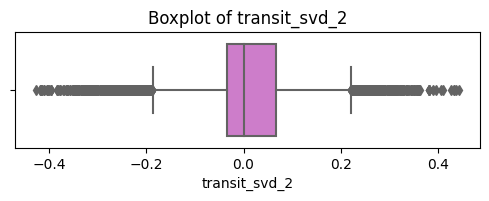

transit_svd_3: عدد الـ outliers = 1526


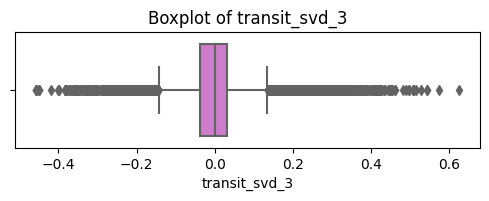

transit_svd_4: عدد الـ outliers = 1144


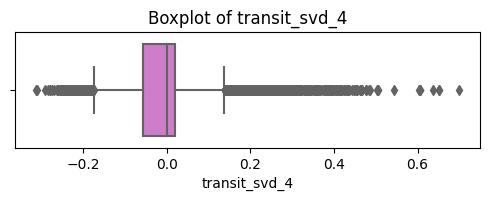

transit_svd_5: عدد الـ outliers = 1468


transit_svd_6: عدد الـ outliers = 1462


transit_svd_7: عدد الـ outliers = 1319


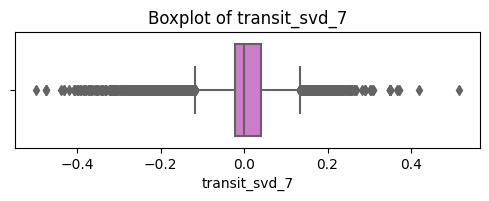

transit_svd_8: عدد الـ outliers = 1167


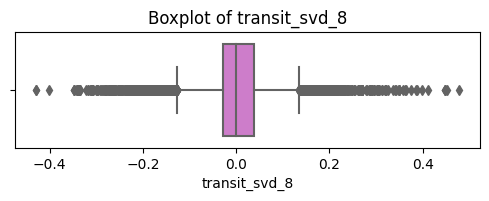

transit_svd_9: عدد الـ outliers = 1252


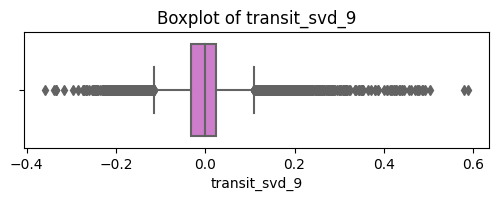

transit_svd_10: عدد الـ outliers = 1460


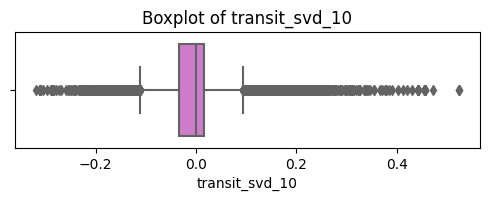

transit_svd_11: عدد الـ outliers = 1452


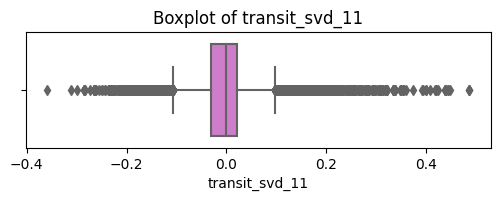

transit_svd_12: عدد الـ outliers = 1253


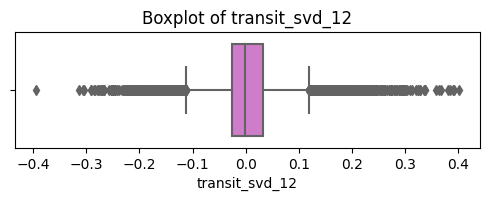

transit_svd_13: عدد الـ outliers = 1389


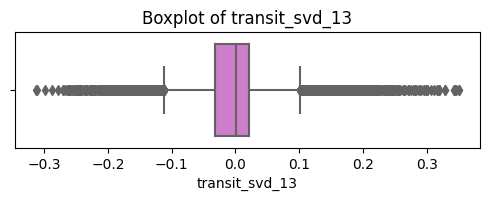

transit_svd_14: عدد الـ outliers = 1393


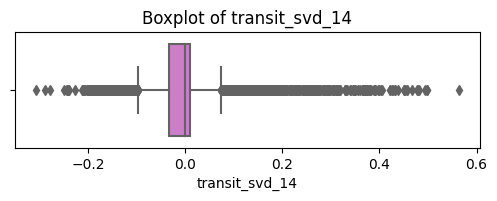

transit_svd_15: عدد الـ outliers = 1370


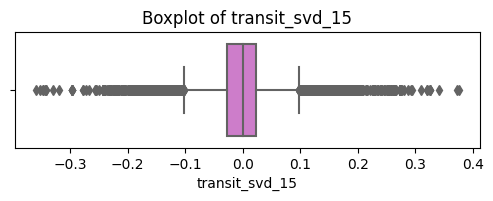

transit_svd_16: عدد الـ outliers = 1199


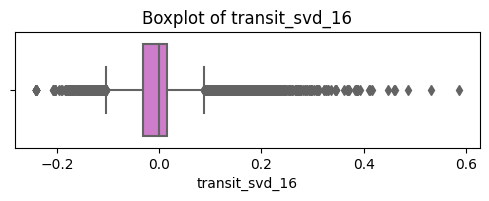

transit_svd_17: عدد الـ outliers = 1202


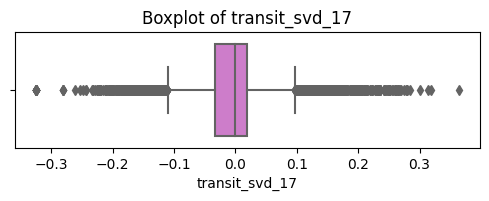

transit_svd_18: عدد الـ outliers = 1339


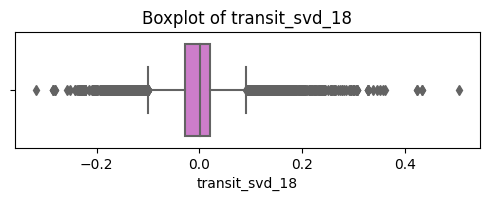

transit_svd_19: عدد الـ outliers = 1387


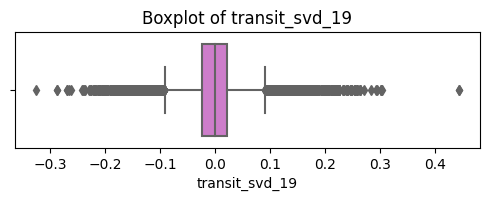

transit_svd_20: عدد الـ outliers = 1216


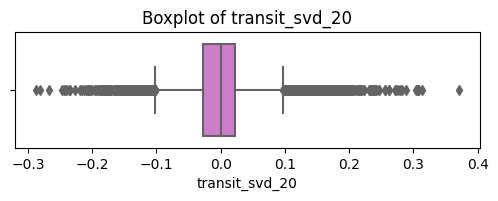

transit_svd_21: عدد الـ outliers = 1305


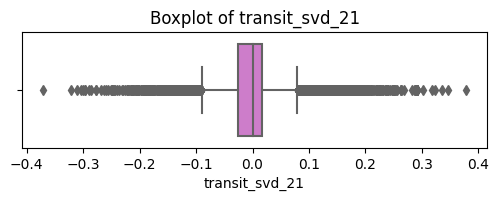

transit_svd_22: عدد الـ outliers = 1226


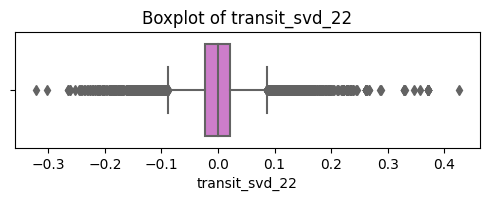

transit_svd_23: عدد الـ outliers = 1157


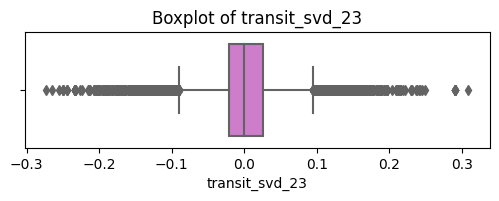

transit_svd_24: عدد الـ outliers = 1269


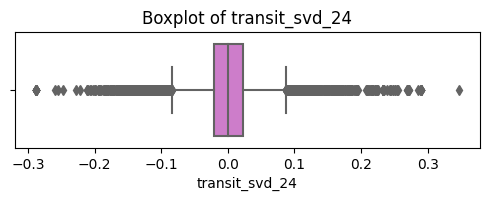

transit_svd_25: عدد الـ outliers = 1161


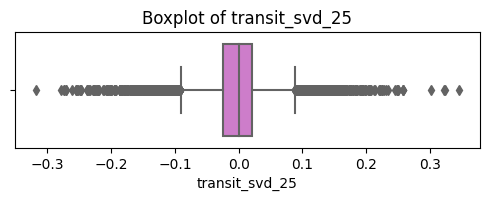

transit_svd_26: عدد الـ outliers = 1318


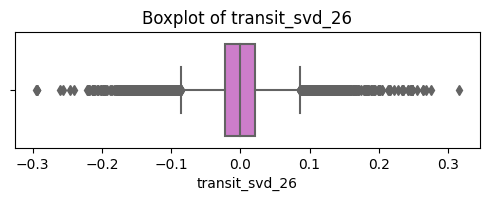

transit_svd_27: عدد الـ outliers = 1157


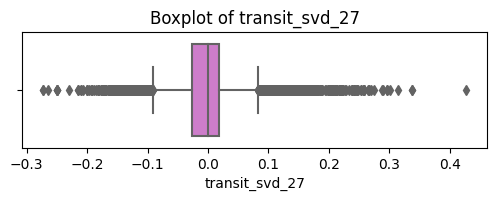

transit_svd_28: عدد الـ outliers = 1205


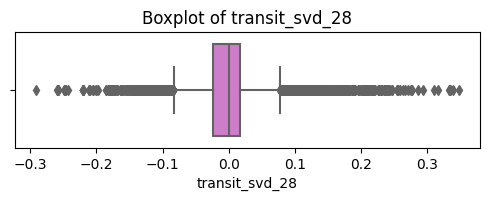

transit_svd_29: عدد الـ outliers = 1280


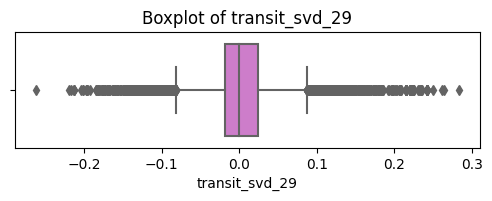

transit_svd_30: عدد الـ outliers = 1239


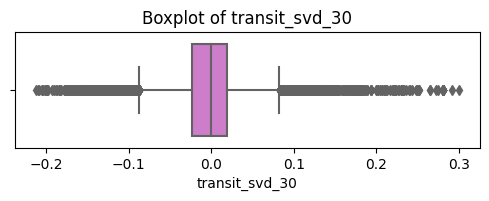

transit_svd_31: عدد الـ outliers = 1107


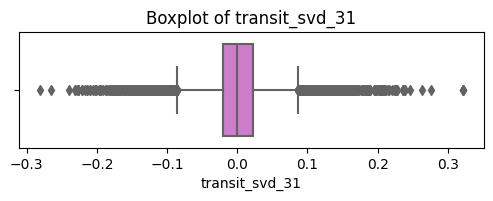

transit_svd_32: عدد الـ outliers = 1237


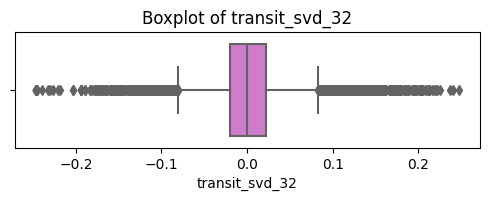

transit_svd_33: عدد الـ outliers = 1320


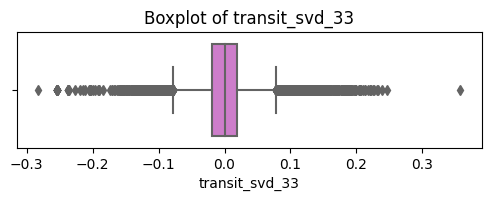

transit_svd_34: عدد الـ outliers = 1181


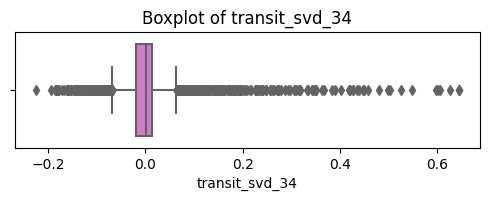

access_svd_0: عدد الـ outliers = 0


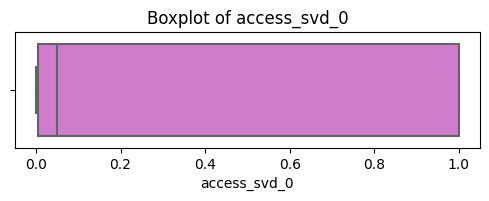

access_svd_1: عدد الـ outliers = 0


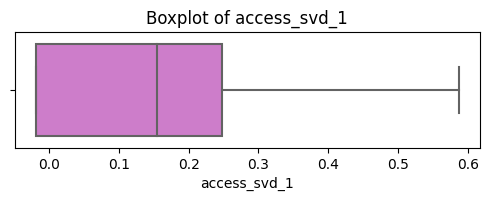

access_svd_2: عدد الـ outliers = 2121


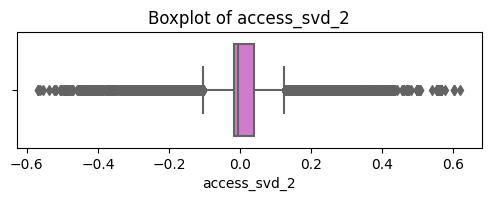

access_svd_3: عدد الـ outliers = 1340


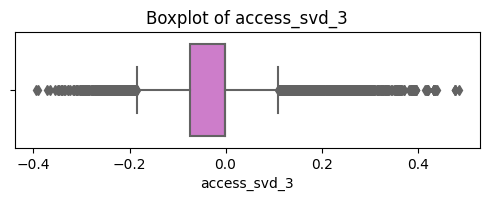

access_svd_4: عدد الـ outliers = 1706


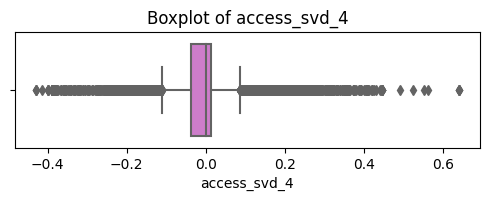

access_svd_5: عدد الـ outliers = 1584


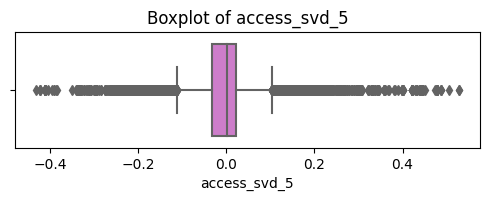

access_svd_6: عدد الـ outliers = 1282


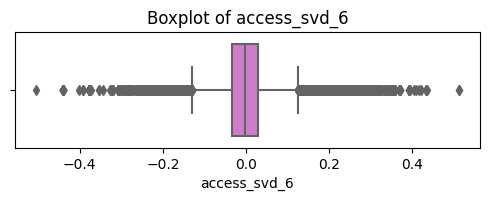

access_svd_7: عدد الـ outliers = 1425


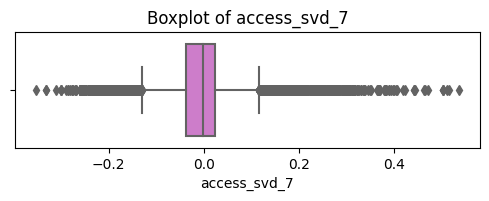

access_svd_8: عدد الـ outliers = 1202


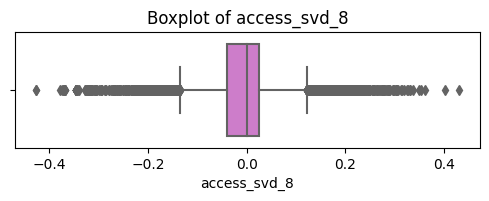

access_svd_9: عدد الـ outliers = 1294


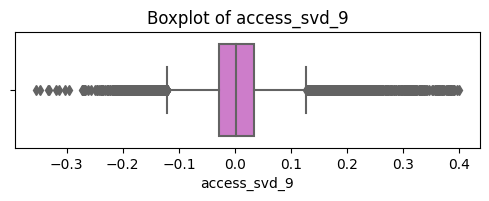

access_svd_10: عدد الـ outliers = 1461


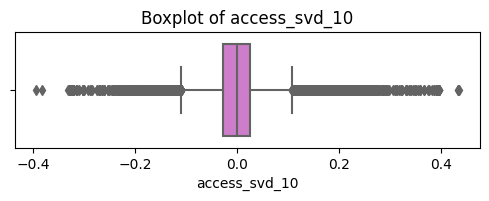

access_svd_11: عدد الـ outliers = 1313


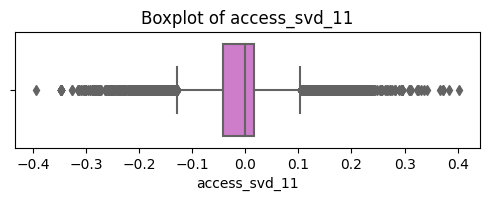

access_svd_12: عدد الـ outliers = 1330


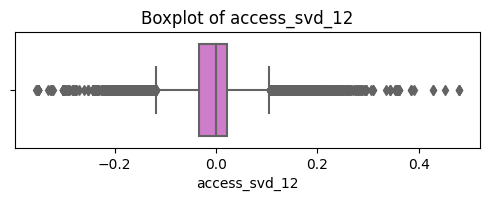

access_svd_13: عدد الـ outliers = 1164


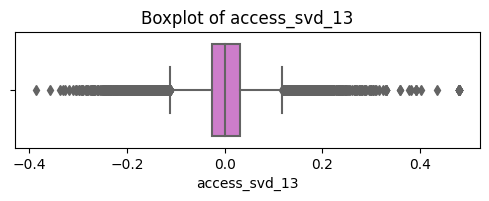

access_svd_14: عدد الـ outliers = 1350


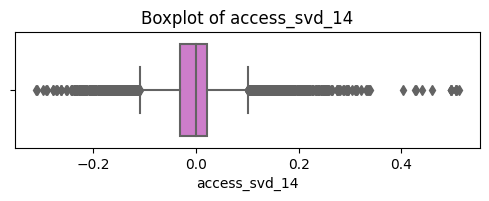

access_svd_15: عدد الـ outliers = 1507


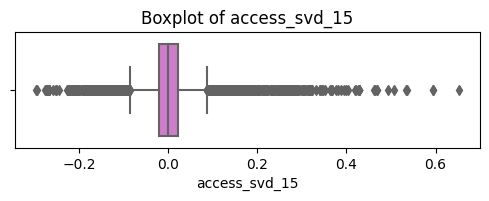

access_svd_16: عدد الـ outliers = 1475


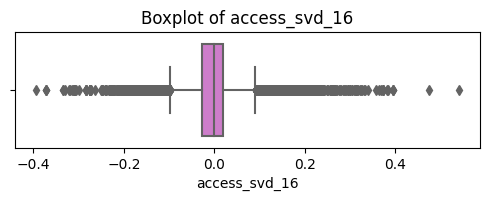

access_svd_17: عدد الـ outliers = 1285


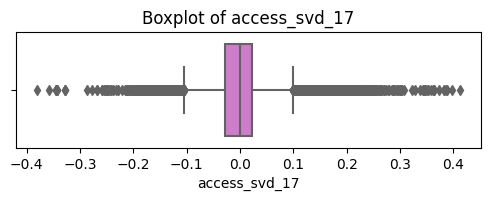

access_svd_18: عدد الـ outliers = 1439


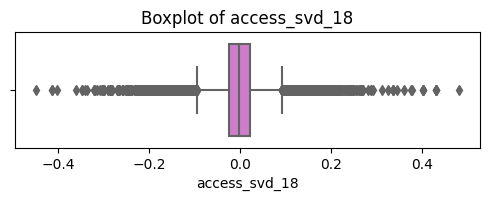

access_svd_19: عدد الـ outliers = 1118


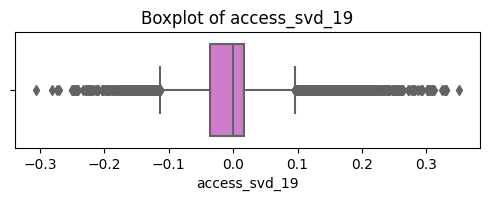

access_svd_20: عدد الـ outliers = 1506


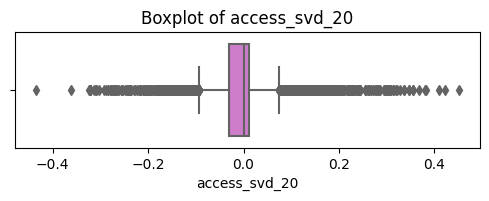

access_svd_21: عدد الـ outliers = 1445


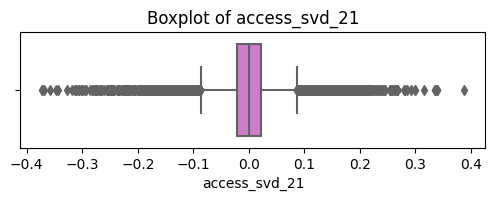

access_svd_22: عدد الـ outliers = 1489


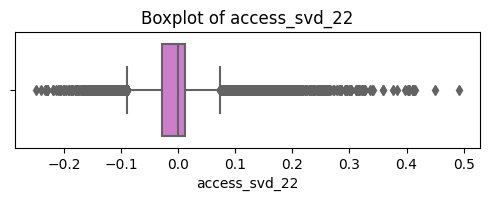

access_svd_23: عدد الـ outliers = 1345


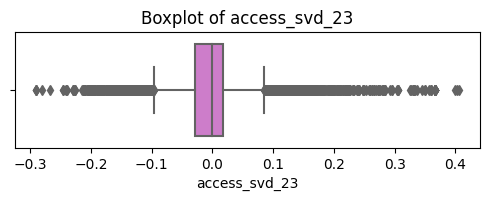

access_svd_24: عدد الـ outliers = 1468


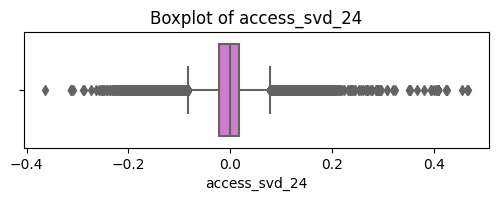

access_svd_25: عدد الـ outliers = 1464


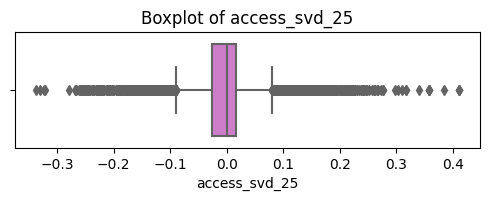

access_svd_26: عدد الـ outliers = 1134


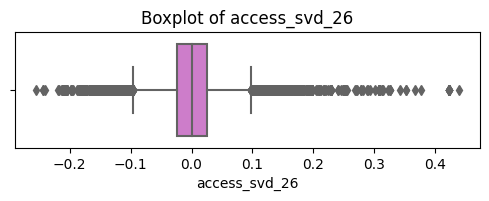

access_svd_27: عدد الـ outliers = 1196


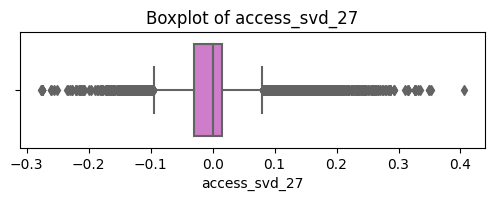

access_svd_28: عدد الـ outliers = 1246


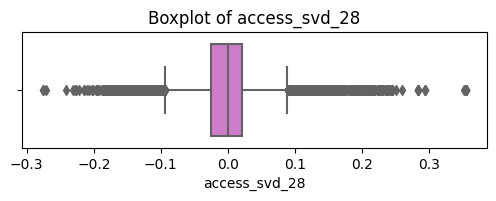

access_svd_29: عدد الـ outliers = 1341


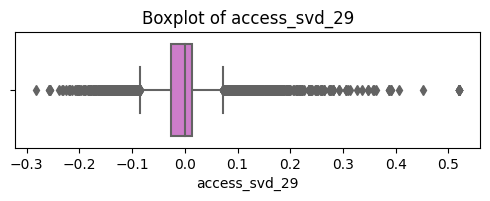

access_svd_30: عدد الـ outliers = 1275


access_svd_31: عدد الـ outliers = 1198


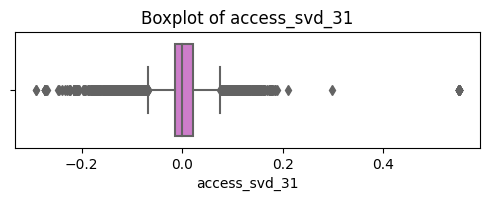

access_svd_32: عدد الـ outliers = 1325


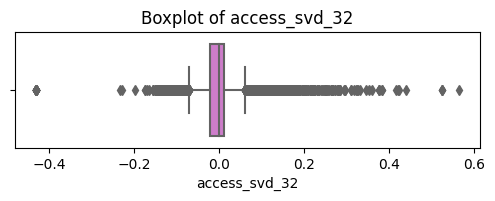

access_svd_33: عدد الـ outliers = 1311


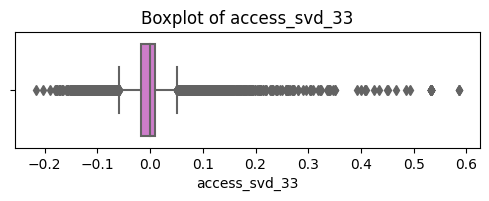

access_svd_34: عدد الـ outliers = 1249


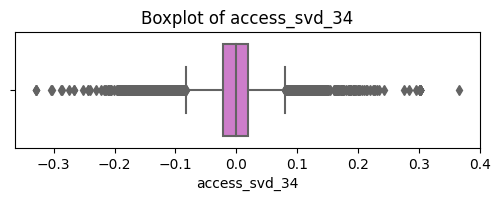

description_svd_0: عدد الـ outliers = 285


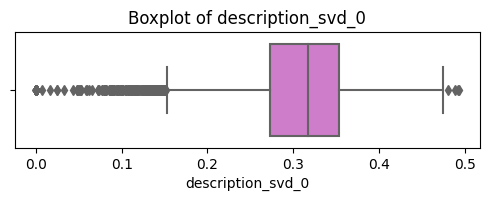

description_svd_1: عدد الـ outliers = 18


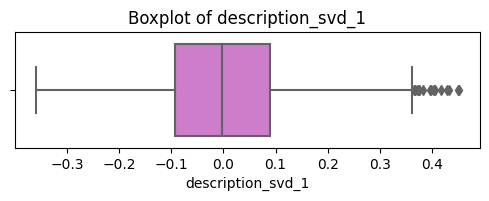

description_svd_2: عدد الـ outliers = 124


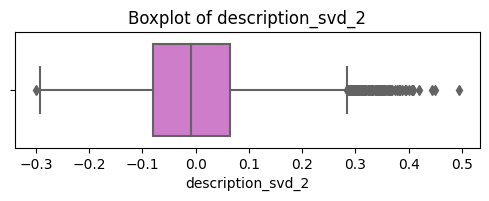

description_svd_3: عدد الـ outliers = 156


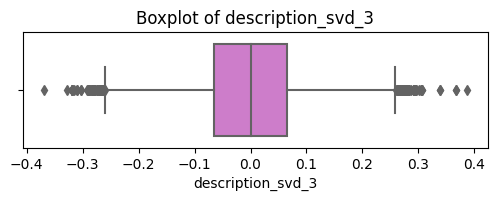

description_svd_4: عدد الـ outliers = 188


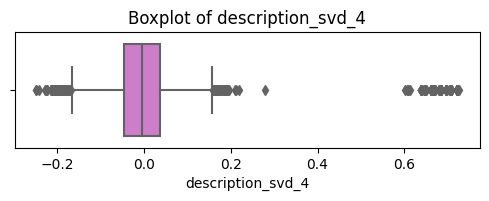

description_svd_5: عدد الـ outliers = 62


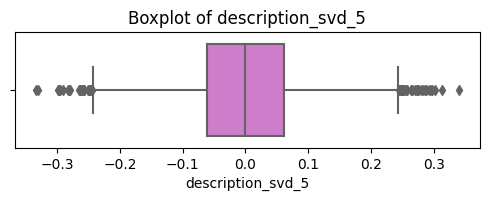

description_svd_6: عدد الـ outliers = 166


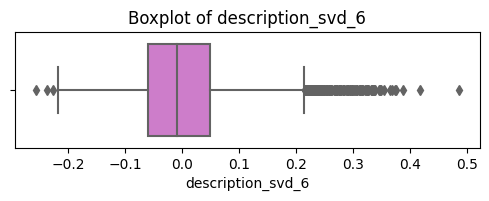

description_svd_7: عدد الـ outliers = 396


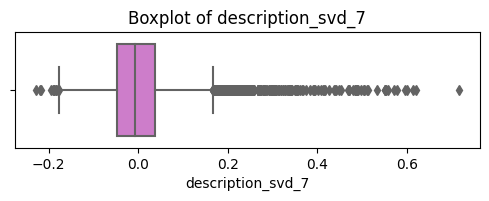

description_svd_8: عدد الـ outliers = 226


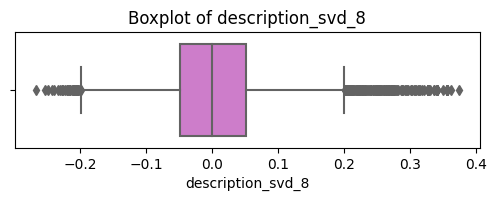

description_svd_9: عدد الـ outliers = 130


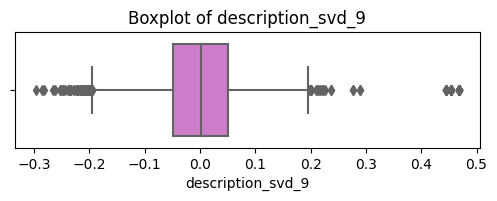

description_svd_10: عدد الـ outliers = 73


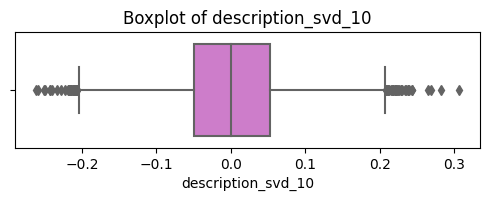

description_svd_11: عدد الـ outliers = 109


description_svd_12: عدد الـ outliers = 131


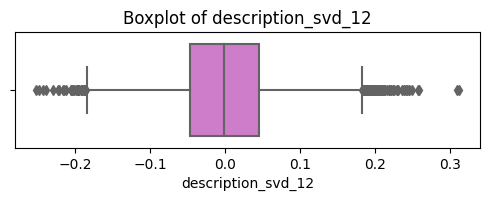

description_svd_13: عدد الـ outliers = 274


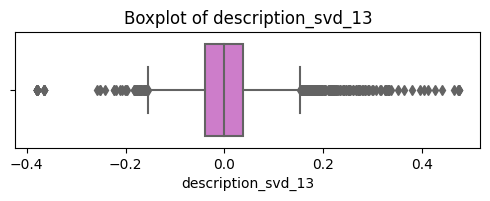

description_svd_14: عدد الـ outliers = 96


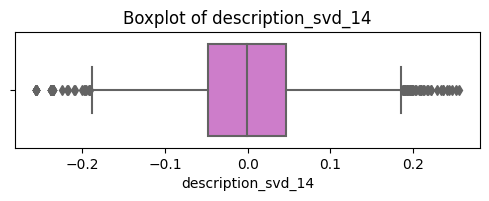

description_svd_15: عدد الـ outliers = 226


description_svd_16: عدد الـ outliers = 230


description_svd_17: عدد الـ outliers = 348


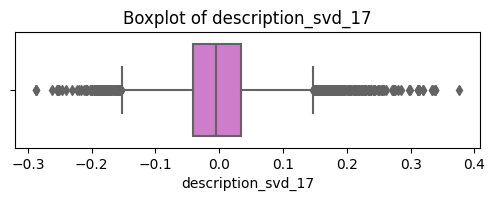

description_svd_18: عدد الـ outliers = 112


description_svd_19: عدد الـ outliers = 228


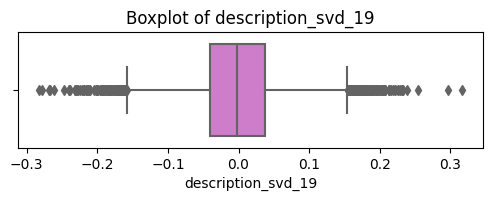

description_svd_20: عدد الـ outliers = 130


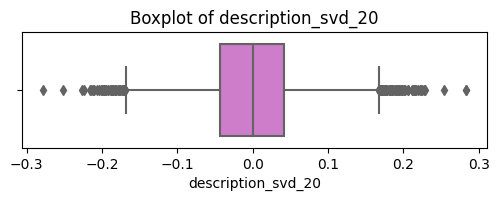

description_svd_21: عدد الـ outliers = 114


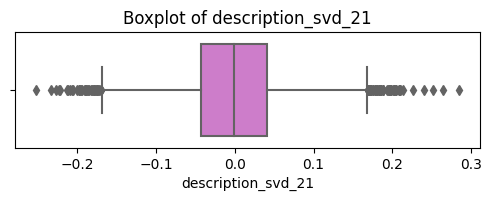

description_svd_22: عدد الـ outliers = 120


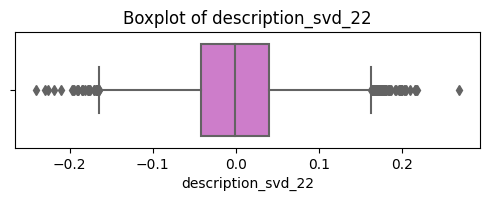

description_svd_23: عدد الـ outliers = 108


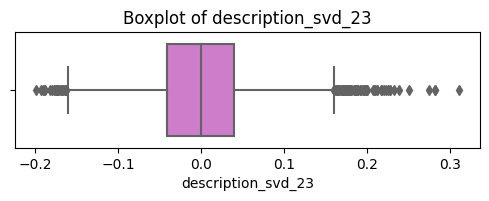

description_svd_24: عدد الـ outliers = 110


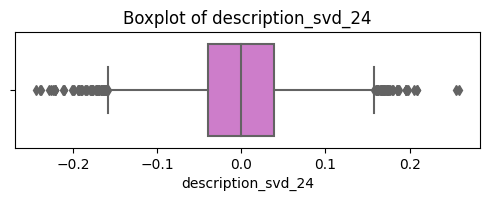

description_svd_25: عدد الـ outliers = 146


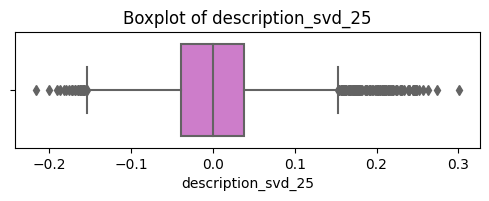

description_svd_26: عدد الـ outliers = 159


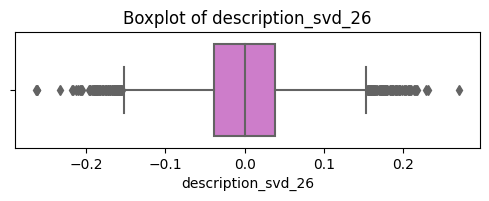

description_svd_27: عدد الـ outliers = 259


description_svd_28: عدد الـ outliers = 235


description_svd_29: عدد الـ outliers = 141


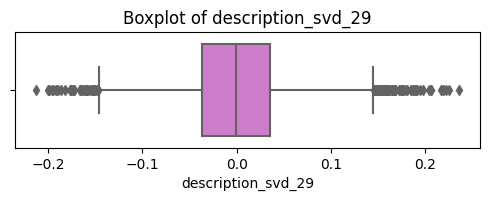

description_svd_30: عدد الـ outliers = 155


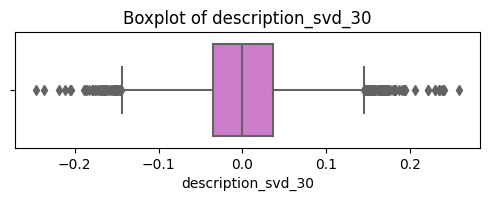

description_svd_31: عدد الـ outliers = 178


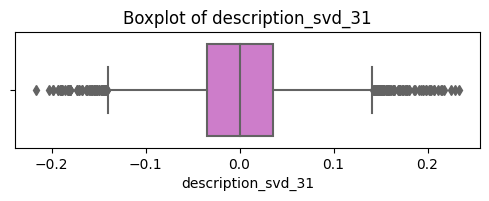

description_svd_32: عدد الـ outliers = 163


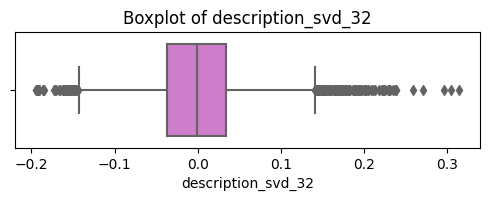

description_svd_33: عدد الـ outliers = 184


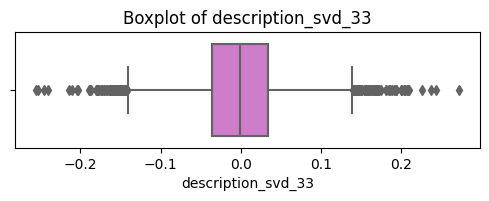

description_svd_34: عدد الـ outliers = 182


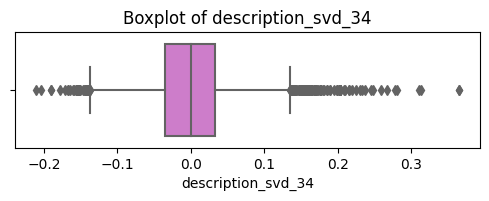

notes_svd_0: عدد الـ outliers = 0


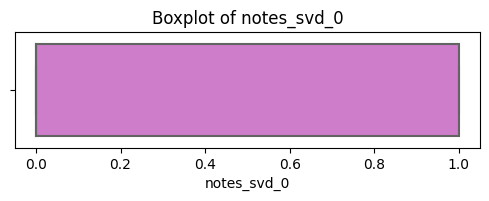

notes_svd_1: عدد الـ outliers = 0


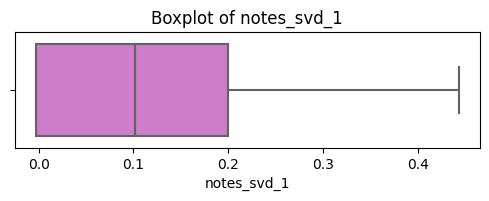

notes_svd_2: عدد الـ outliers = 1212


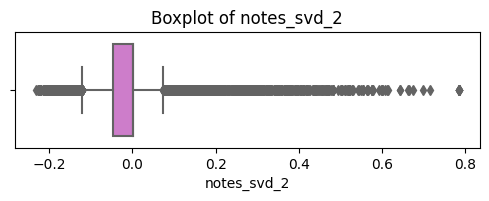

notes_svd_3: عدد الـ outliers = 2180


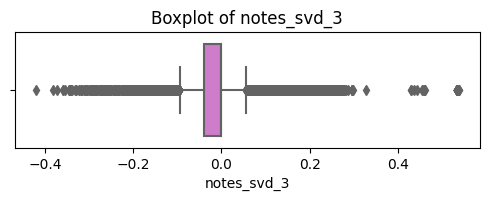

notes_svd_4: عدد الـ outliers = 1852


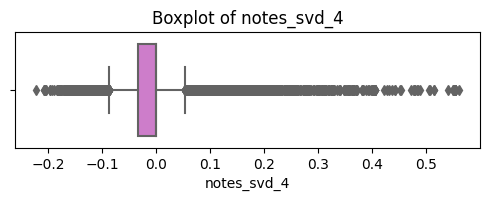

notes_svd_5: عدد الـ outliers = 2276


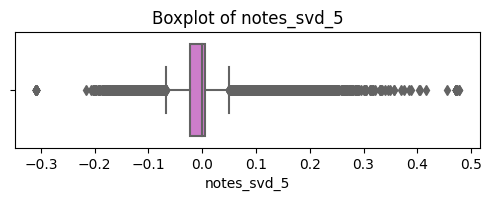

notes_svd_6: عدد الـ outliers = 2565


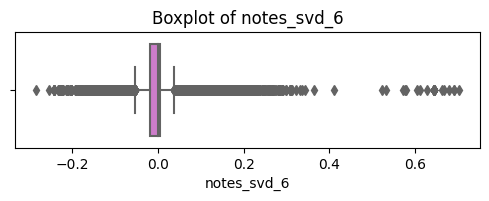

notes_svd_7: عدد الـ outliers = 2333


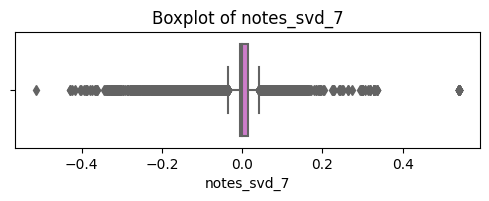

notes_svd_8: عدد الـ outliers = 2434


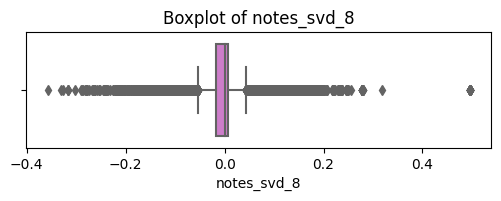

notes_svd_9: عدد الـ outliers = 2230


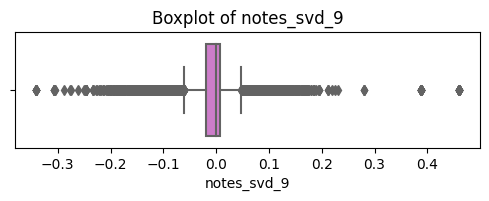

notes_svd_10: عدد الـ outliers = 2493


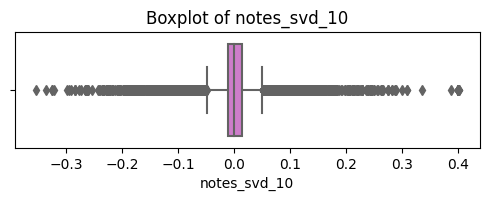

notes_svd_11: عدد الـ outliers = 2488


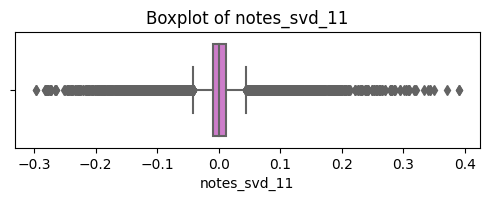

notes_svd_12: عدد الـ outliers = 2469


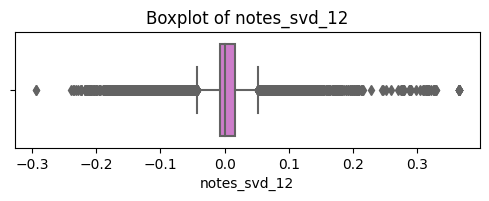

notes_svd_13: عدد الـ outliers = 2387


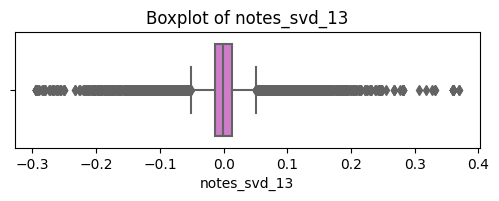

notes_svd_14: عدد الـ outliers = 2384


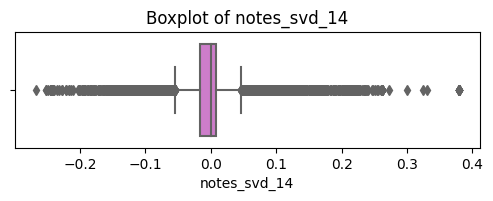

notes_svd_15: عدد الـ outliers = 2265


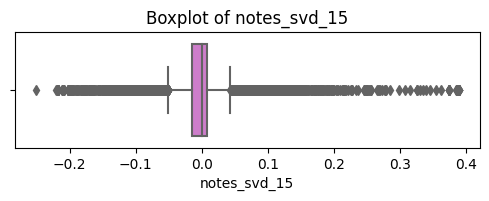

notes_svd_16: عدد الـ outliers = 2134


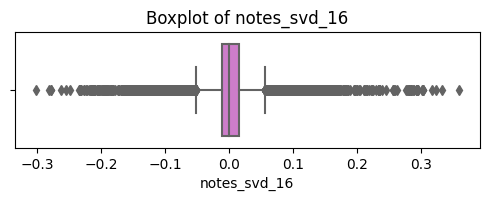

notes_svd_17: عدد الـ outliers = 2430


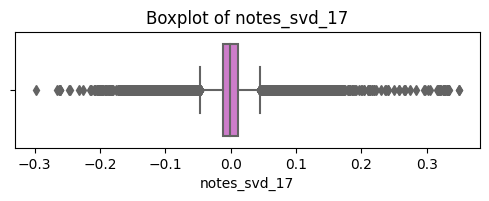

notes_svd_18: عدد الـ outliers = 2258


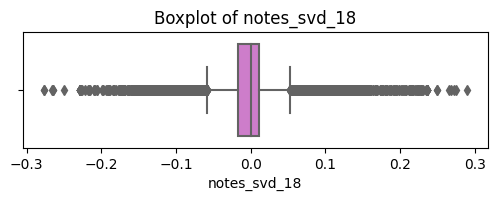

notes_svd_19: عدد الـ outliers = 2300


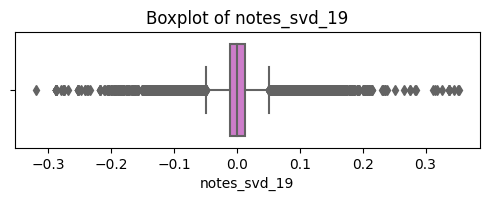

notes_svd_20: عدد الـ outliers = 2237


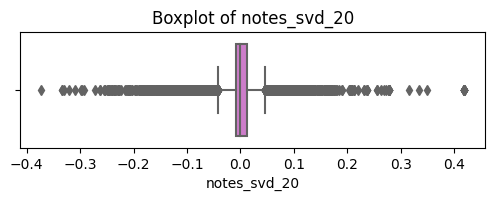

notes_svd_21: عدد الـ outliers = 2390


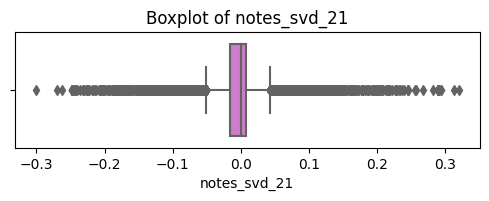

notes_svd_22: عدد الـ outliers = 2115


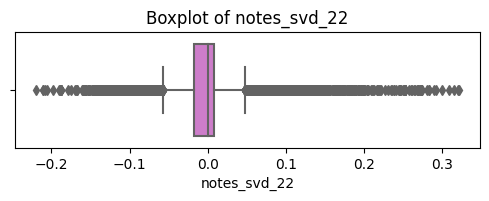

notes_svd_23: عدد الـ outliers = 2188


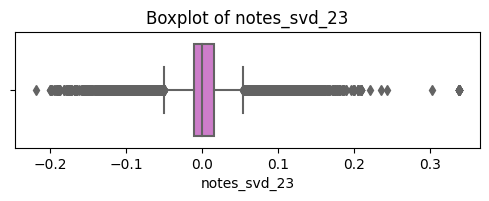

notes_svd_24: عدد الـ outliers = 2302


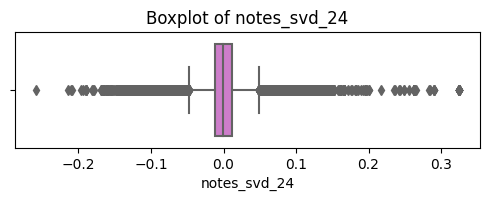

notes_svd_25: عدد الـ outliers = 2251


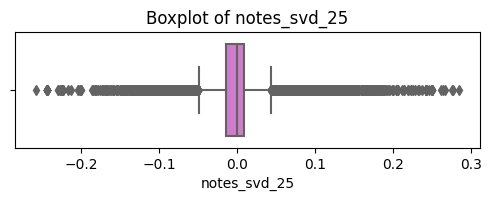

notes_svd_26: عدد الـ outliers = 2134


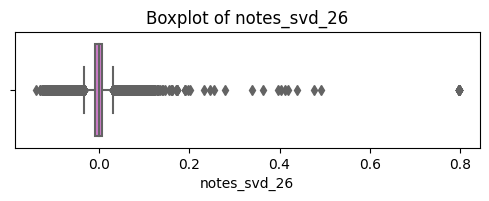

notes_svd_27: عدد الـ outliers = 2248


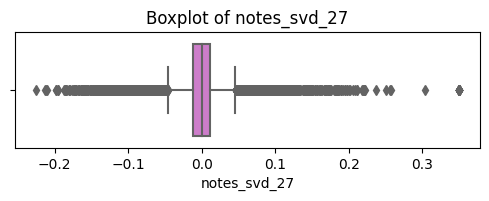

notes_svd_28: عدد الـ outliers = 2174


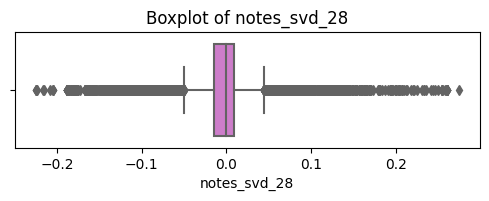

notes_svd_29: عدد الـ outliers = 2331


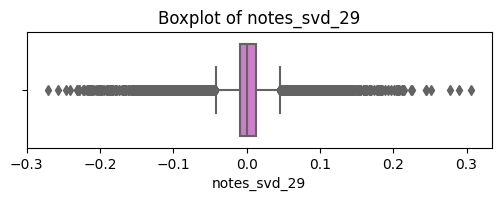

notes_svd_30: عدد الـ outliers = 2327


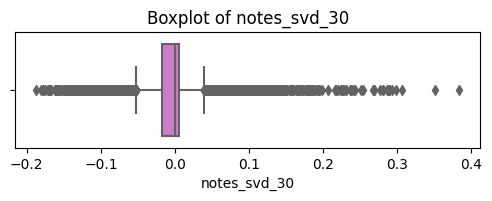

notes_svd_31: عدد الـ outliers = 2213


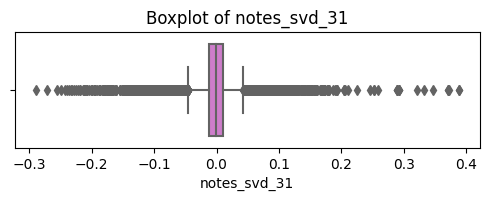

notes_svd_32: عدد الـ outliers = 2272


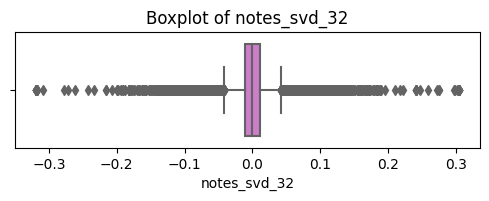

notes_svd_33: عدد الـ outliers = 2320


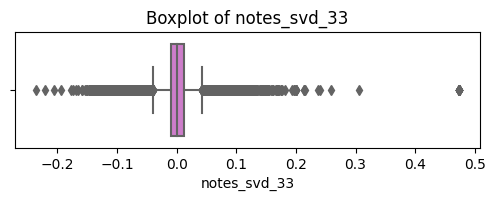

notes_svd_34: عدد الـ outliers = 2187


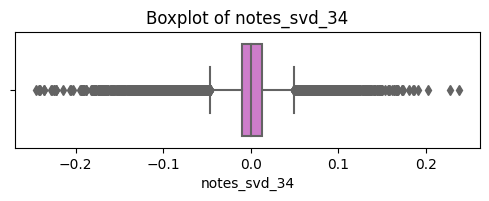

house_rules_svd_0: عدد الـ outliers = 1973


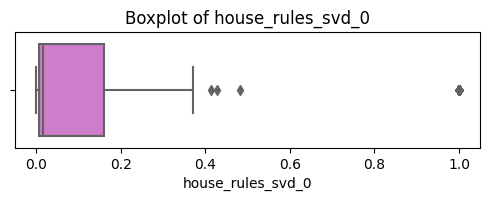

house_rules_svd_1: عدد الـ outliers = 0


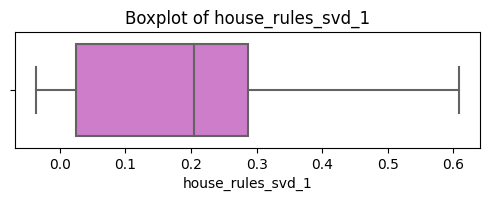

house_rules_svd_2: عدد الـ outliers = 389


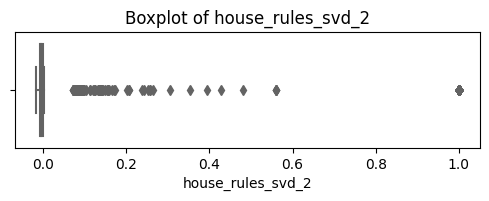

house_rules_svd_3: عدد الـ outliers = 1713


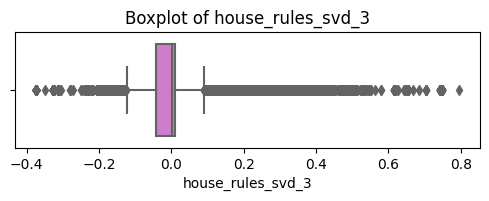

house_rules_svd_4: عدد الـ outliers = 831


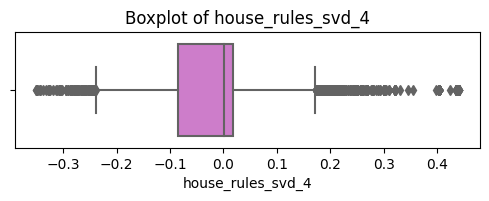

house_rules_svd_5: عدد الـ outliers = 1006


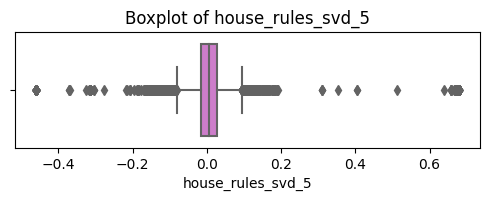

house_rules_svd_6: عدد الـ outliers = 1014


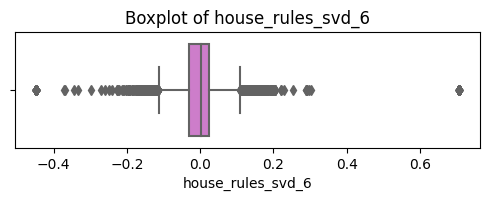

house_rules_svd_7: عدد الـ outliers = 860


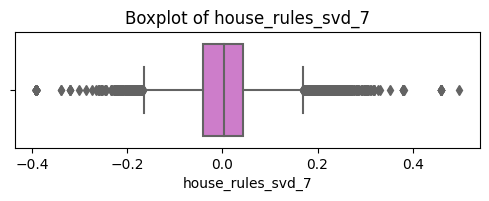

house_rules_svd_8: عدد الـ outliers = 809


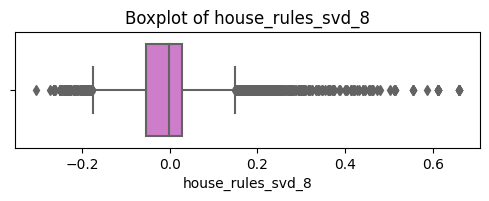

house_rules_svd_9: عدد الـ outliers = 1849


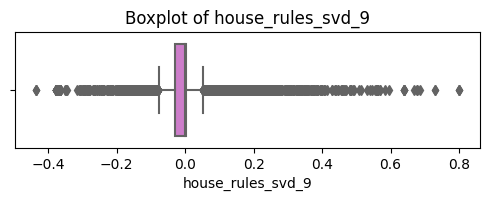

house_rules_svd_10: عدد الـ outliers = 1272


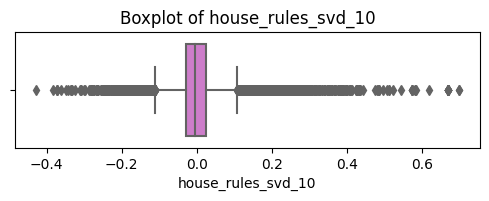

house_rules_svd_11: عدد الـ outliers = 987


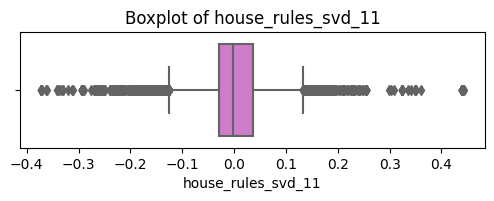

house_rules_svd_12: عدد الـ outliers = 1042


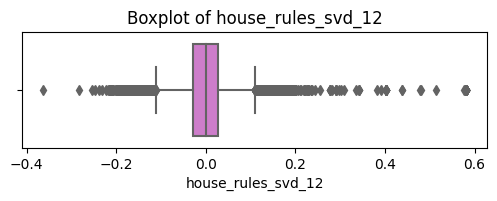

house_rules_svd_13: عدد الـ outliers = 1090


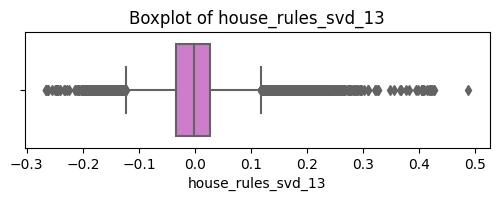

house_rules_svd_14: عدد الـ outliers = 910


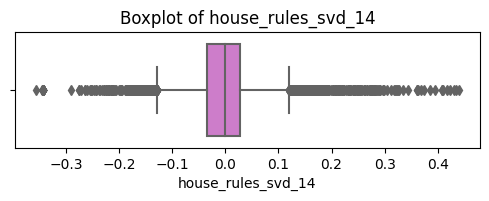

house_rules_svd_15: عدد الـ outliers = 804


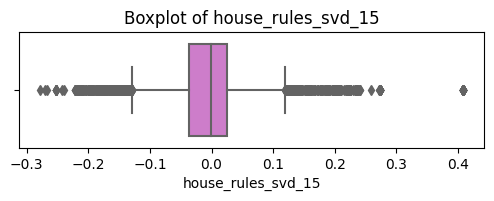

house_rules_svd_16: عدد الـ outliers = 914


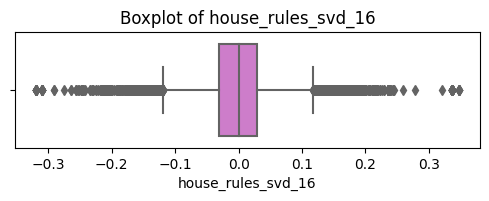

house_rules_svd_17: عدد الـ outliers = 908


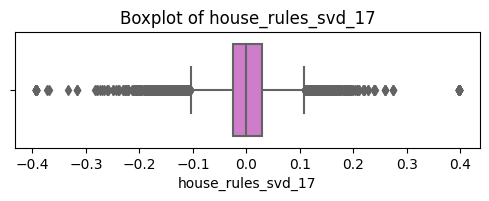

house_rules_svd_18: عدد الـ outliers = 839


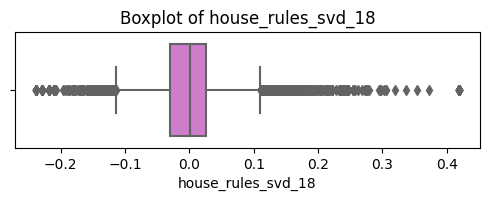

house_rules_svd_19: عدد الـ outliers = 1023


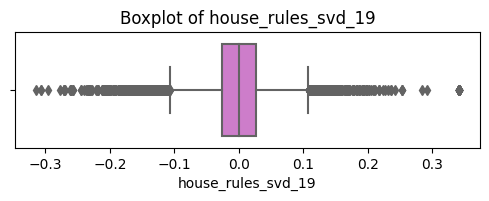

house_rules_svd_20: عدد الـ outliers = 982


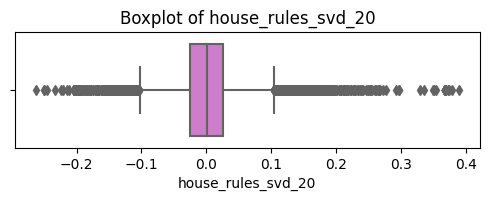

house_rules_svd_21: عدد الـ outliers = 999


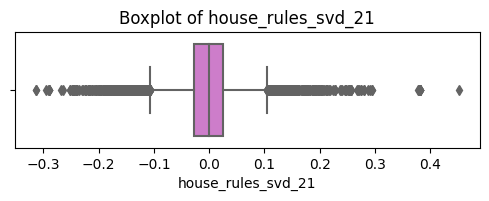

house_rules_svd_22: عدد الـ outliers = 704


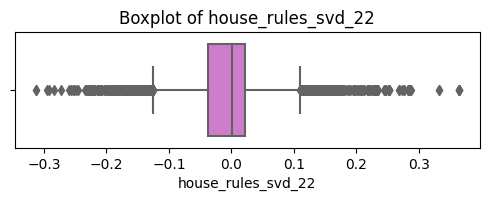

house_rules_svd_23: عدد الـ outliers = 802


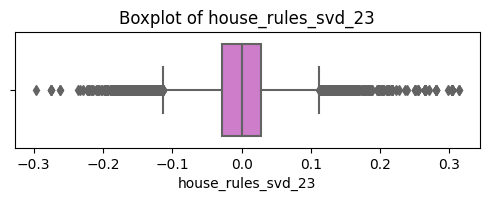

house_rules_svd_24: عدد الـ outliers = 735


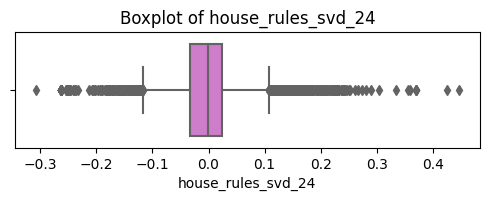

house_rules_svd_25: عدد الـ outliers = 1135


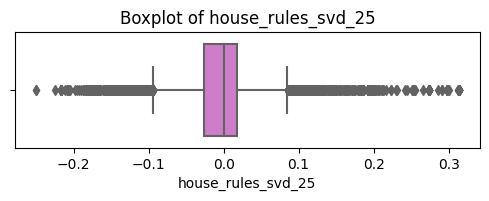

house_rules_svd_26: عدد الـ outliers = 1106


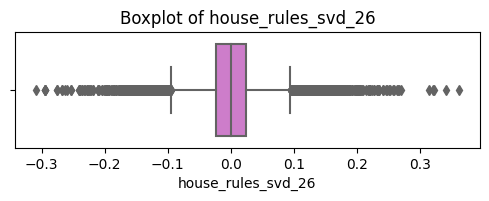

house_rules_svd_27: عدد الـ outliers = 1102


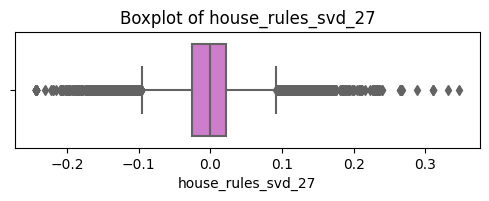

house_rules_svd_28: عدد الـ outliers = 1248


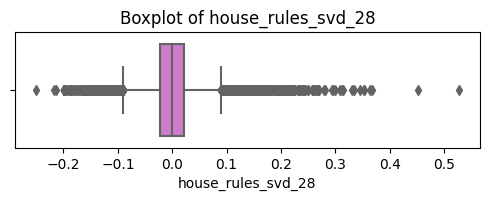

house_rules_svd_29: عدد الـ outliers = 1062


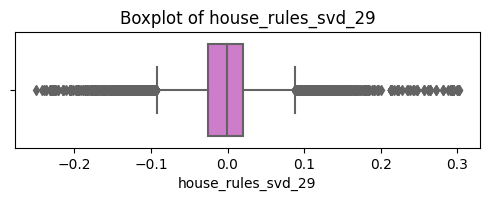

house_rules_svd_30: عدد الـ outliers = 1134


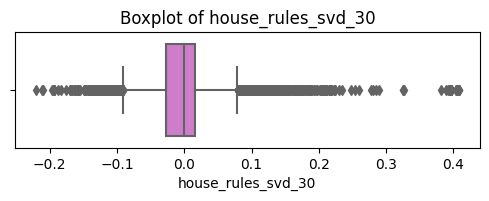

house_rules_svd_31: عدد الـ outliers = 1050


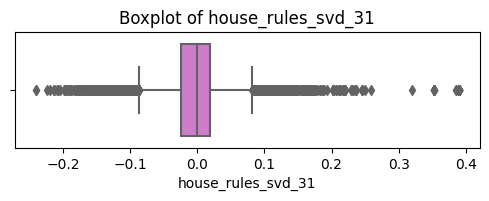

house_rules_svd_32: عدد الـ outliers = 1048


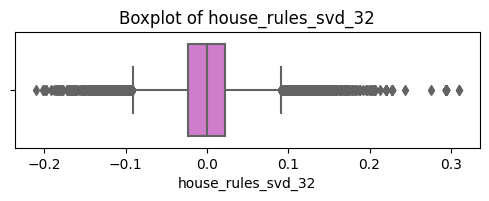

house_rules_svd_33: عدد الـ outliers = 901


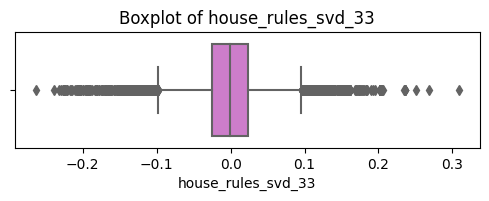

house_rules_svd_34: عدد الـ outliers = 1113


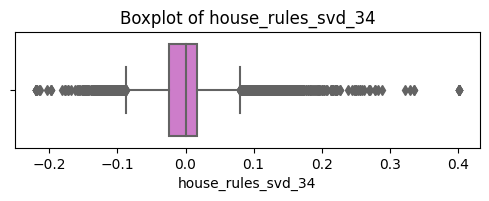

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: عدد الـ outliers = {outliers.shape[0]}")

    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=df[col], color='orchid')
    plt.title(f'Boxplot of {col}')
    plt.show()


 Handling Outliers using IQR method

In [ ]:
outliers_cols = [
    'host_total_listings_count',
    "latitude", "longitude",
    "accommodates", "bathrooms", "bedrooms", "beds",
    "guests_included", "minimum_nights",
    "maximum_nights", "number_of_reviews", "number_of_stays",'review_scores_rating','host_listings_count'
]

In [ ]:
for col in outliers_cols:
  q1 = np.percentile(df[col], 25)
  q3 = np.percentile(df[col], 75)
  norm_range = (q3 - q1) * 1.5
  lower_outliers = df[df[col] < (q1 - norm_range)]
  upper_outliers = df[df[col] > (q3 + norm_range)]
  outliers = len(lower_outliers)+len(upper_outliers)
  print(f"The number of outliers in {col} is : {outliers}\n")
chunks = [outliers_cols[i::4] for i in range(4)]

The number of outliers in host_total_listings_count is : 1301

The number of outliers in latitude is : 521

The number of outliers in longitude is : 46

The number of outliers in accommodates is : 179

The number of outliers in bathrooms is : 219

The number of outliers in bedrooms is : 627

The number of outliers in beds is : 317

The number of outliers in guests_included is : 504

The number of outliers in minimum_nights is : 629

The number of outliers in maximum_nights is : 4

The number of outliers in number_of_reviews is : 755

The number of outliers in number_of_stays is : 755

The number of outliers in review_scores_rating is : 475

The number of outliers in host_listings_count is : 1301



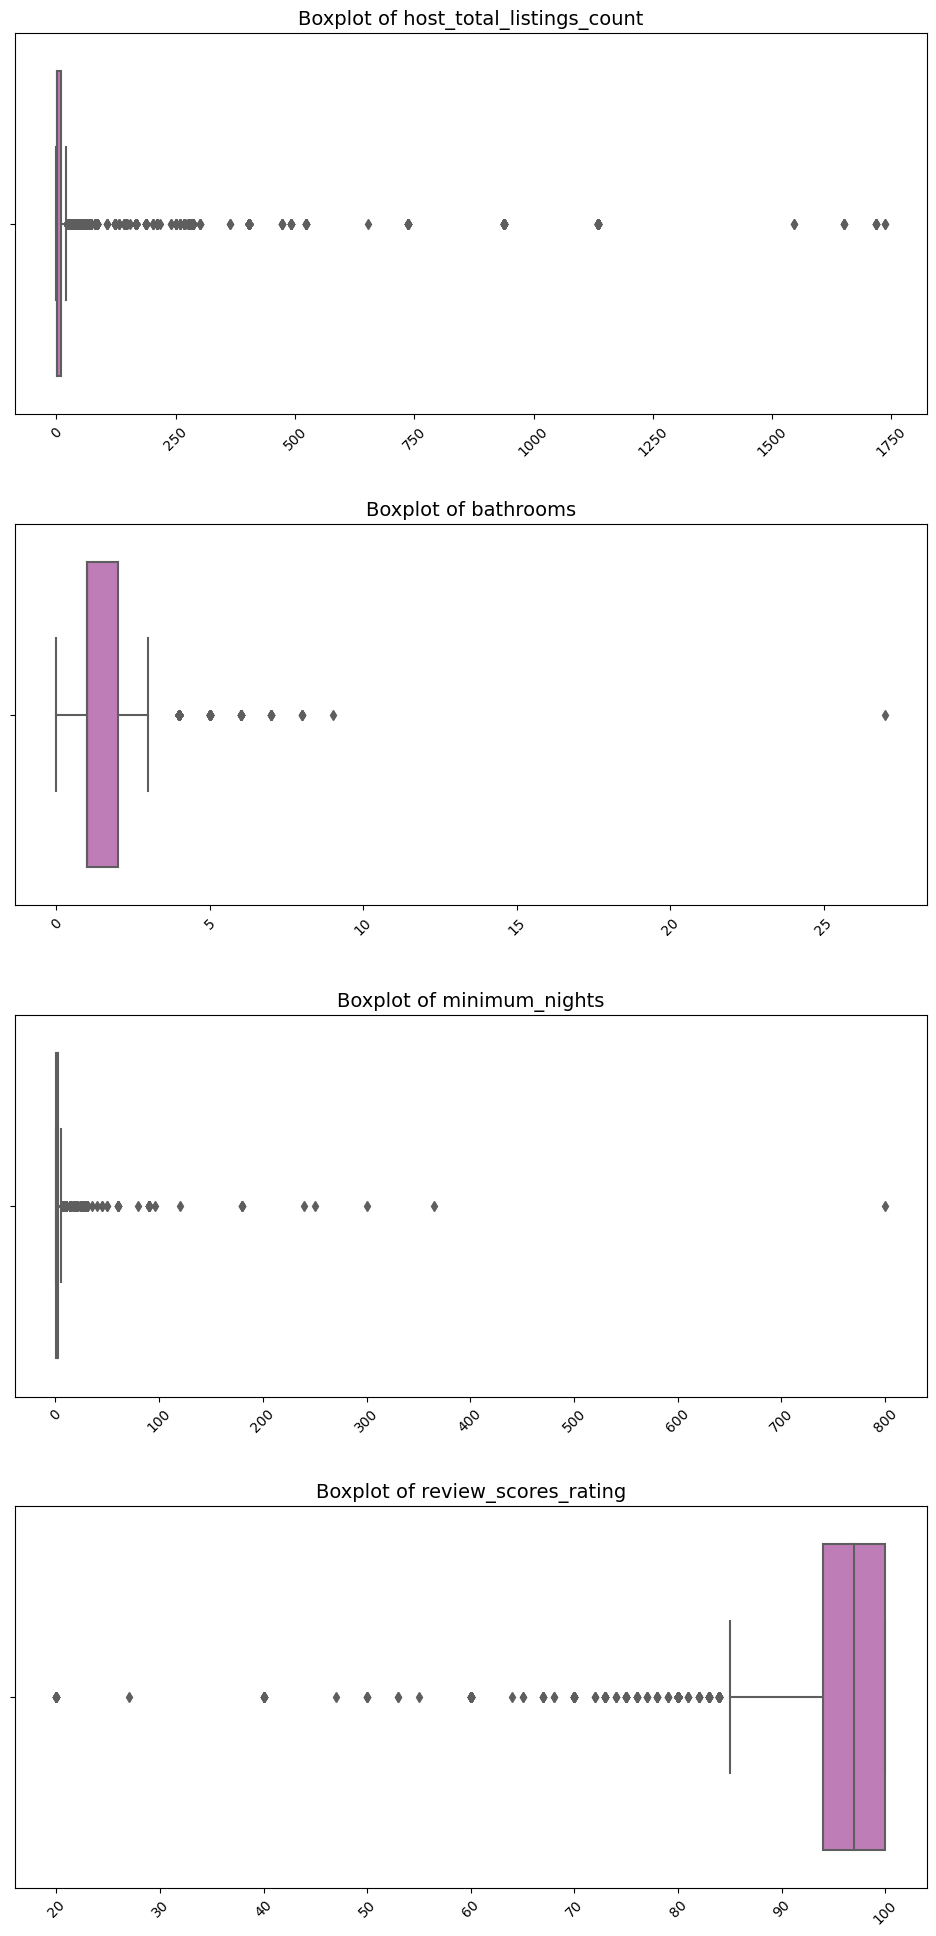

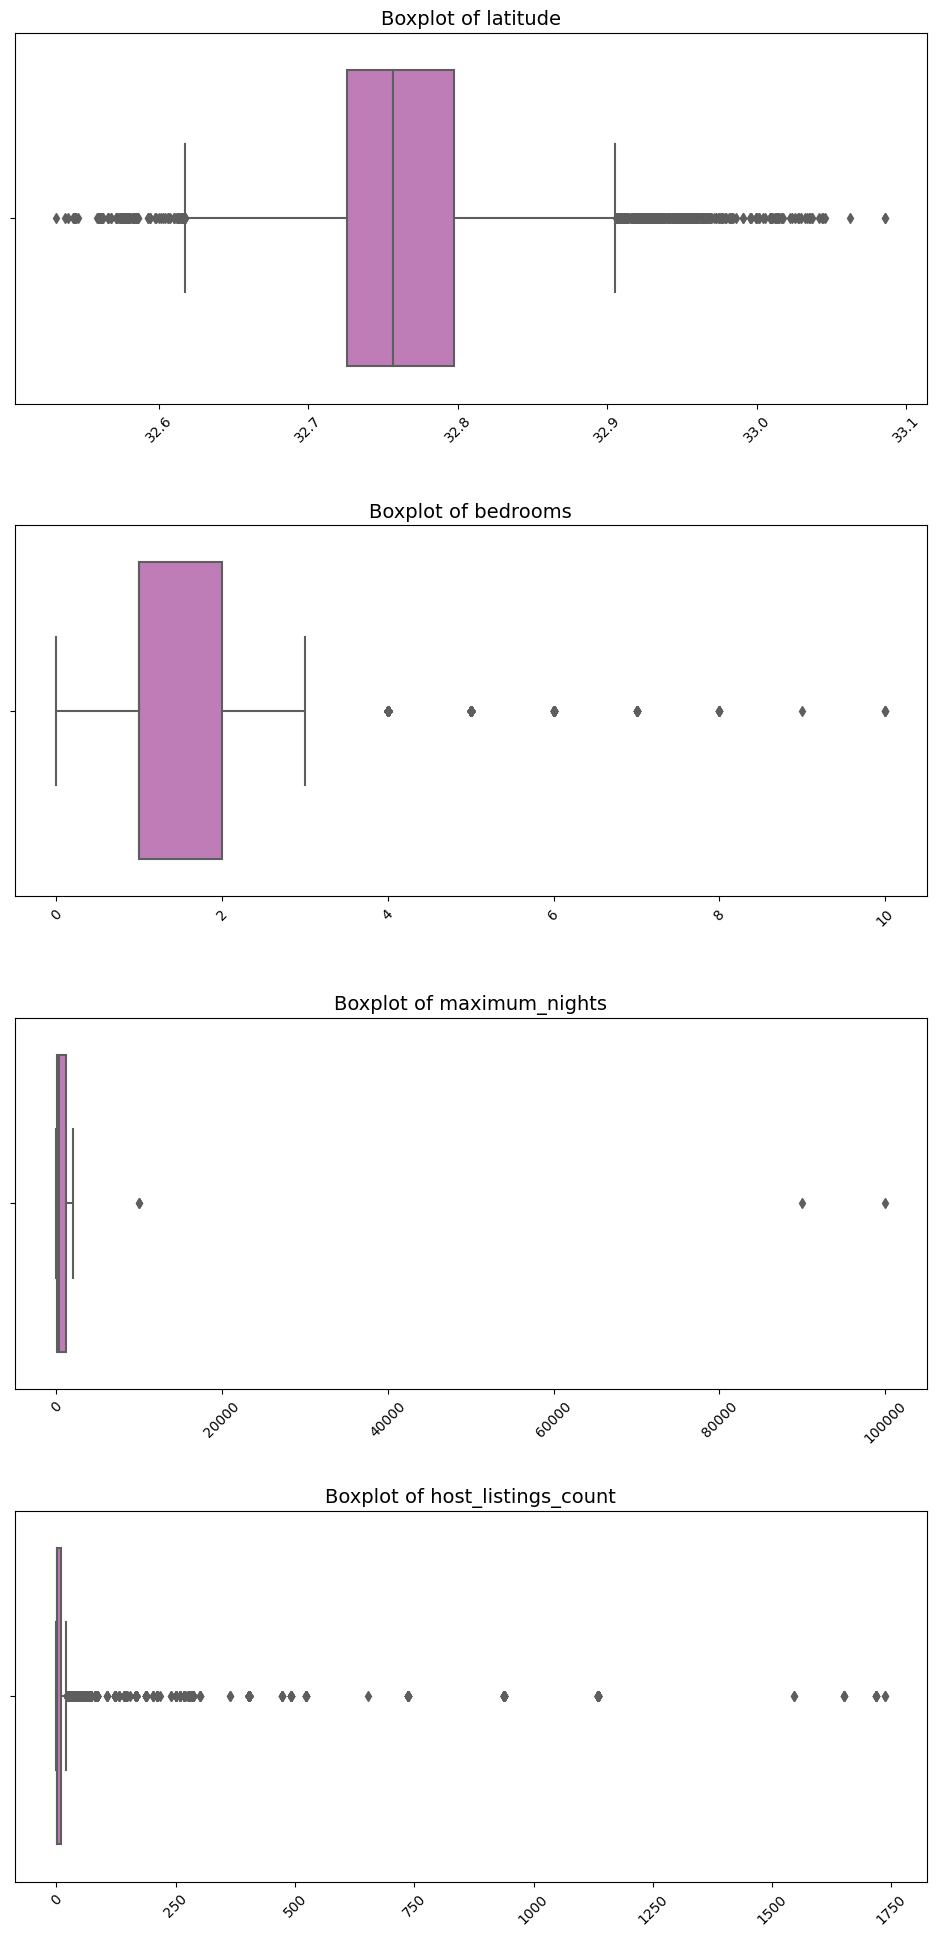

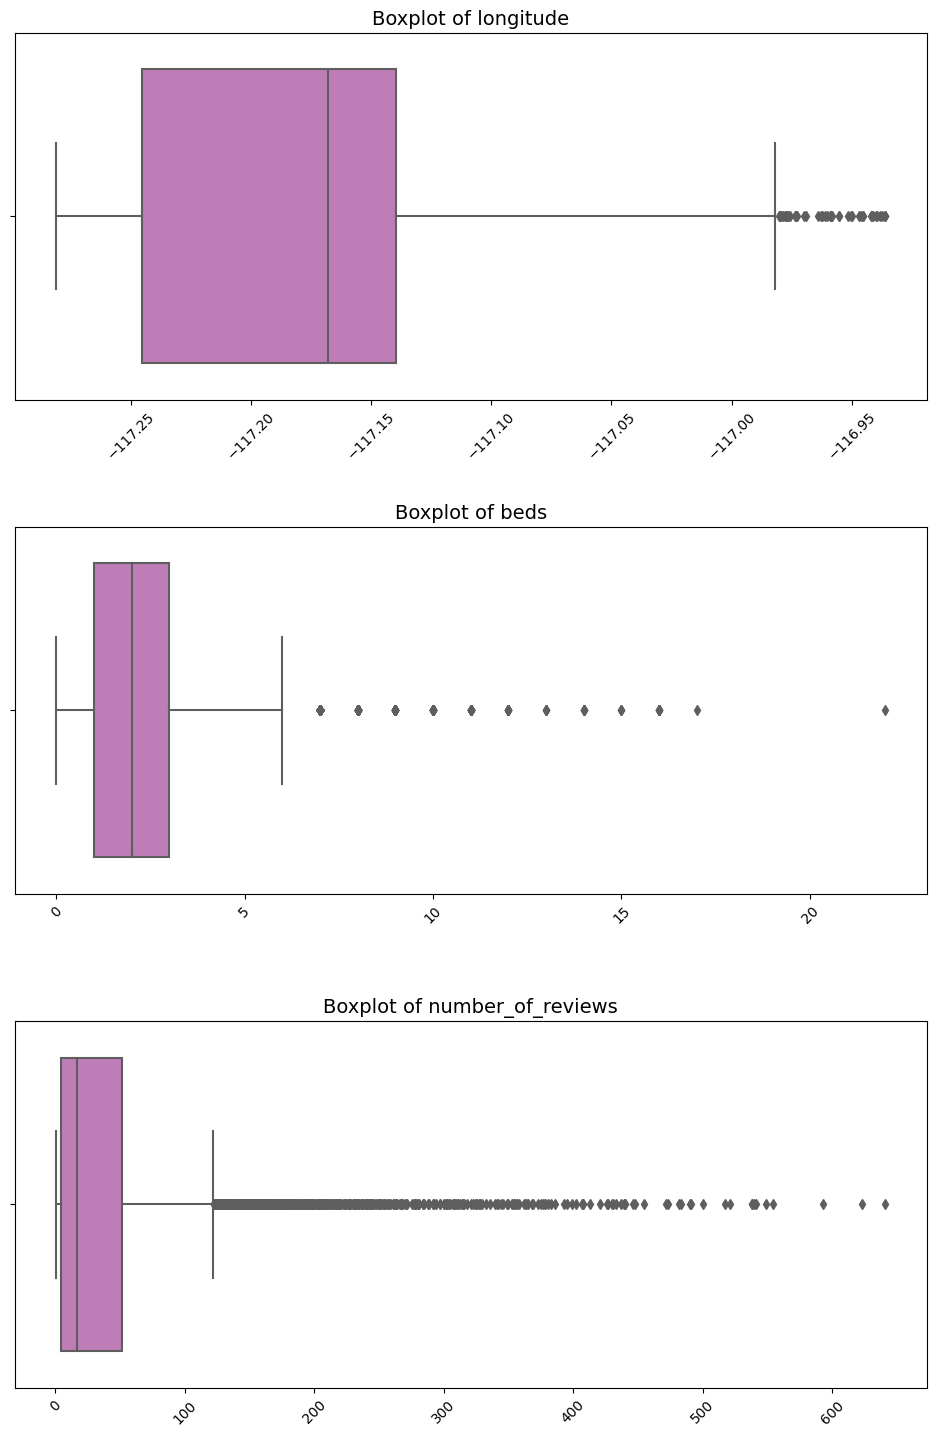

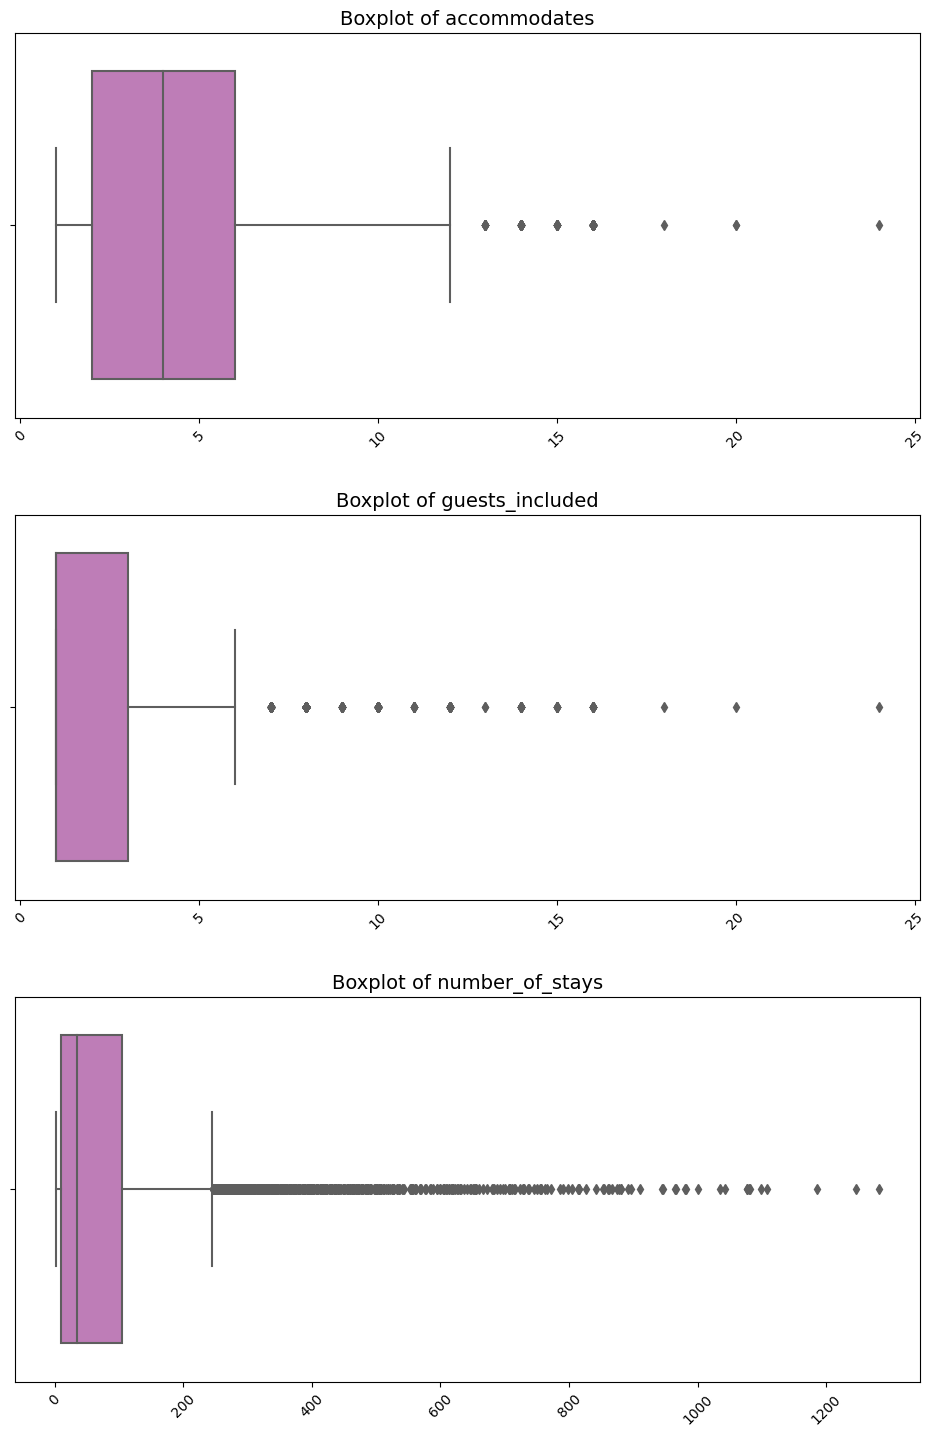

In [ ]:
for group in chunks:
    fig, axes = plt.subplots(len(group), 1, figsize=(10, len(group) * 5))  # Make it taller
    if len(group) == 1:
        axes = [axes]

    for ax, col in zip(axes, group):
        sns.boxplot(x=df[col], palette=["#C972BF"], ax=ax)
        ax.set_title(f'Boxplot of {col}', fontsize=14)
        ax.set_xlabel('')  # Remove x-label
        ax.tick_params(axis='x', rotation=45)  # Rotate x-ticks by 45 degrees

    plt.tight_layout(pad=3.0)  # Add padding between plots
    plt.show()

In [ ]:
for col in outliers_cols:
  q1 = np.percentile(df[col], 25)
  q3 = np.percentile(df[col], 75)
  norm_range = (q3 - q1) * 1.5
  df[col] = np.where(df[col] < (q1 - norm_range), q1 - norm_range, df[col])
  df[col] = np.where(df[col] > (q3 + norm_range), q3 + norm_range, df[col])

In [ ]:
for col in outliers_cols:
  q1 = np.percentile(df[col], 25)
  q3 = np.percentile(df[col], 75)
  norm_range = (q3 - q1) * 1.5
  lower_outliers = df[df[col] < (q1 - norm_range)]
  upper_outliers = df[df[col] > (q3 + norm_range)]
  outliers = len(lower_outliers)+len(upper_outliers)
  print(f"AFTER HANDLING OUTLIERS: The number of outliers in {col} is : {outliers}")

AFTER HANDLING OUTLIERS: The number of outliers in host_total_listings_count is : 0
AFTER HANDLING OUTLIERS: The number of outliers in latitude is : 0
AFTER HANDLING OUTLIERS: The number of outliers in longitude is : 0
AFTER HANDLING OUTLIERS: The number of outliers in accommodates is : 0
AFTER HANDLING OUTLIERS: The number of outliers in bathrooms is : 0
AFTER HANDLING OUTLIERS: The number of outliers in bedrooms is : 0
AFTER HANDLING OUTLIERS: The number of outliers in beds is : 0
AFTER HANDLING OUTLIERS: The number of outliers in guests_included is : 0
AFTER HANDLING OUTLIERS: The number of outliers in minimum_nights is : 0
AFTER HANDLING OUTLIERS: The number of outliers in maximum_nights is : 0
AFTER HANDLING OUTLIERS: The number of outliers in number_of_reviews is : 0
AFTER HANDLING OUTLIERS: The number of outliers in number_of_stays is : 0
AFTER HANDLING OUTLIERS: The number of outliers in review_scores_rating is : 0
AFTER HANDLING OUTLIERS: The number of outliers in host_listing

Feature Engineering

Dividing amenities into categories
#NOTE:We cleaned and parsed the `amenities` column, extracted all individual items, and grouped them into meaningful categories (e.g., Essentials, Safety, Luxury). For each listing,
# we counted how many amenities belong to each category and added these counts as new features to the dataset.


In [ ]:
all_amenities = set()

for amenities in df['amenities']:
    amenities = amenities.strip()
    if amenities.startswith("{") and amenities.endswith("}"):
        amenities = amenities[1:-1]

    items = [item.strip().strip('"').strip("'") for item in amenities.split(",")]
    all_amenities.update(items)

for amenity in sorted(all_amenities):
    print(amenity)


24-hour check-in
Accessible-height bed
Accessible-height toilet
Air conditioning
Air purifier
Alfresco bathtub
Amazon Echo
BBQ grill
Baby bath
Baby monitor
Babysitter recommendations
Balcony
Bath towel
Bathroom essentials
Bathtub
Bathtub with bath chair
Beach essentials
Beach view
Beachfront
Bed linens
Bedroom comforts
Bidet
Body soap
Breakfast
Breakfast table
Building staff
Buzzer/wireless intercom
Cable TV
Carbon monoxide detector
Cat(s)
Ceiling fan
Central air conditioning
Changing table
Children’s books and toys
Children’s dinnerware
Cleaning before checkout
Coffee maker
Convection oven
Cooking basics
Crib
DVD player
Day bed
Disabled parking spot
Dishes and silverware
Dishwasher
Dog(s)
Doorman
Double oven
Dryer
EV charger
Electric profiling bed
Elevator
En suite bathroom
Espresso machine
Essentials
Ethernet connection
Exercise equipment
Extra pillows and blankets
Extra space around bed
Family/kid friendly
Fax machine
Fire extinguisher
Fire pit
Fireplace guards
Firm mattress
First 

In [ ]:
amenities_dict = {
    "Essentials": [
        "Essentials", "Bath towel", "Bathroom essentials", "Bed linens", "Bedroom comforts",
        "Body soap", "Cooking basics", "Dishes and silverware", "Hangers", "Heating",
        "Hot water", "Internet", "Shampoo", "Toilet paper", "Wifi", "TV", "Cleaning before checkout",
        "Ethernet connection", "Hair dryer", "Hot water kettle", "toilet"
    ],
    "Safety": [
        "Carbon monoxide detector", "Fire extinguisher", "First aid kit", "Safety card",
        "Smoke detector", "Window guards", "Buzzer/wireless intercom",
        "Lock on bedroom door", "Doorman", "Smart lock", "Keypad", "Fireplace guards"
    ],
    "Luxury": [
        "Air purifier", "Alfresco bathtub", "En suite bathroom", "Espresso machine", "Firm mattress",
        "Heated floors", "Heated towel rack", "Hot tub", "Jetted tub", "Memory foam mattress",
        "Pillow-top mattress", "Private hot tub", "Private pool", "Rain shower", "Sauna",
        "Soaking tub", "Sound system", "Stand alone steam shower", "Sun loungers", "Wine cooler",
        "Building staff", "Day bed", "Host greets you", "Indoor fireplace", "Luggage dropoff allowed",
        "Private bathroom", "Private entrance", "Private living room", "Room-darkening shades",
        "Suitable for events", "Ski-in/Ski-out", "Smoking allowed"
    ],
    "Accessibility": [
        "24-hour check-in", "Accessible-height bed", "Accessible-height toilet", "Disabled parking spot",
        "Electric profiling bed", "Elevator", "Extra space around bed", "Flat path to guest entrance",
        "Ground floor access", "Handheld shower head", "No stairs or steps to enter",
        "Pool with pool hoist", "Roll-in shower", "Shower chair", "Single level home",
        "Well-lit path to entrance", "Wheelchair accessible", "Wide clearance to shower",
        "Wide doorway to guest bathroom", "Wide entrance", "Wide entrance for guests",
        "Wide entryway", "Wide hallways", "Fixed grab bars for shower", "Fixed grab bars for toilet",
        "Bathtub with bath chair"
    ],
    "Outdoor": [
        "BBQ grill", "Balcony", "Beach essentials", "Beach view", "Beachfront",
        "Free parking on premises", "Free street parking", "Garden or backyard", "Hammock",
        "Lake access", "Mountain view", "Outdoor kitchen", "Outdoor parking",
        "Outdoor seating", "Patio or balcony", "Terrace", "Waterfront", "Tennis court",
        "Pool", "Pool toys", "Fire pit"
    ],
    "Child & Family-Friendly": [
        "Baby bath", "Baby monitor", "Babysitter recommendations", "Changing table",
        "Children's books and toys", "Children's dinnerware", "Crib", "Family/kid friendly",
        "High chair", "Outlet covers", "Pack 'n Play/travel crib", "Stair gates",
        "Table corner guards", "Other pet(s)", "Pets allowed", "Cat(s)", "Dog(s)", "Pets live on this property"
    ],
    "Entertainment": [
        "Amazon Echo", "Cable TV", "DVD player", "Game console", "HBO GO",
        "Netflix", "Projector and screen", "Smart TV"
    ],
    "Home Appliances": [
        "Air conditioning", "Ceiling fan", "Central air conditioning", "Coffee maker",
        "Convection oven", "Dishwasher", "Dryer", "EV charger", "Exercise equipment",
        "Fax machine", "Full kitchen", "Gas oven", "Gym", "High-resolution computer monitor",
        "Kitchen", "Kitchenette", "Laptop friendly workspace", "Lockbox", "Long term stays allowed",
        "Microwave", "Mini fridge", "Murphy bed", "Oven", "Paid parking off premises",
        "Paid parking on premises", "Printer", "Refrigerator", "Stove", "Washer",
        "Warming drawer", "Pocket wifi", "Shared gym", "Shared hot tub", "Shared pool",
        "Self check-in", "Extra pillows and blankets", "Formal dining area", "Standing valet",
        "Iron", "Double oven", "Heat lamps", "Breakfast", "Breakfast table", "Bidet"
    ]
}

In [ ]:
amenity_to_category = {}
for category, amenities in amenities_dict.items():
    for amenity in amenities:
        amenity_to_category[amenity] = category

all_categories = list(amenities_dict.keys())

In [ ]:
from collections import defaultdict
def categorize_amenities(amenities_str):
    if pd.isna(amenities_str):
        amenities = []
    else:
        amenities_str = amenities_str.strip()
        if amenities_str.startswith("{") and amenities_str.endswith("}"):
            amenities_str = amenities_str[1:-1]
        amenities = [item.strip().strip('"').strip("'") for item in amenities_str.split(",")]

    counts = defaultdict(int)
    for amenity in amenities:
        if amenity:
            category = amenity_to_category.get(amenity)
            if category:
                counts[category] += 1

    full_counts = {cat: counts.get(cat, 0) for cat in all_categories}
    return pd.Series(full_counts)
category_counts_df = df["amenities"].apply(categorize_amenities)

In [ ]:
df = pd.concat([df, category_counts_df], axis=1)
print("AFTER DIVIDING AMENTIES INTO CATEGORIES:\n",df[['amenities','Essentials','Safety','Luxury','Accessibility','Outdoor','Child & Family-Friendly','Entertainment','Home Appliances']].head(5))
print(df.shape)

AFTER DIVIDING AMENTIES INTO CATEGORIES:
                                            amenities  Essentials  Safety  \
0  {TV,Wifi,"Air conditioning",Pool,Kitchen,"Free...           6       3   
1  {TV,"Cable TV",Wifi,Kitchen,"Free parking on p...           9       4   
2  {TV,Internet,Wifi,"Air conditioning",Kitchen,"...          11       3   
3  {TV,Wifi,"Air conditioning",Kitchen,"Paid park...          16       4   
4  {TV,Wifi,"Air conditioning",Kitchen,"Paid park...          11       7   

   Luxury  Accessibility  Outdoor  Child & Family-Friendly  Entertainment  \
0       2              1        2                        0              0   
1       1              1        5                        1              1   
2       2              0        5                        2              0   
3       0              1        2                        1              0   
4       2              2        4                        1              0   

   Home Appliances  
0                

Extracting New features from date columns

Extracting number of active years from host since column

In [ ]:
from datetime import datetime

df['host_since'] = pd.to_datetime(df['host_since'], format='%m/%d/%Y')

today = pd.to_datetime(datetime.today())
df['years_active'] = (today - df['host_since']).dt.days / 365

df['years_active'] = df['years_active'].round(1)

print(df[['years_active','host_since']].head())

   years_active host_since
0          12.8 2012-10-15
1          12.5 2013-01-29
2          11.7 2013-11-05
3           7.3 2018-04-11
4          11.9 2013-08-23


Extracting review frequency per day from last_review,first_review and number_of_reviews columns

In [ ]:
df['first_review'] = pd.to_datetime(df['first_review'], format='%m/%d/%Y')
df['last_review'] = pd.to_datetime(df['last_review'], format='%m/%d/%Y')

df['reviews_per_day'] = df.apply(
    lambda row: row['number_of_reviews'] / ((row['last_review'] - row['first_review']).days)
    if (row['last_review'] - row['first_review']).days != 0 else 0,
    axis=1
)

df['reviews_per_day'] = df['reviews_per_day'].round(4)

print(df[['reviews_per_day', 'first_review', 'last_review', 'number_of_reviews']].head())

   reviews_per_day first_review last_review  number_of_reviews
0           0.0000   2017-11-17  2017-11-17                1.0
1           0.0059   2013-08-02  2019-07-31               13.0
2           0.1176   2017-07-23  2019-07-16               85.0
3           0.2309   2018-05-01  2019-08-03              106.0
4           0.0000   2019-06-30  2019-06-30                1.0


Dividing host location column into host city , host state and host country

In [ ]:
print(df['host_location'].unique())
def split_host_location(location):

    if location in ['us', 'ca', 'at', 'gb', 'mx', 'it', 'de', 'canada', 'china', 'mexico', 'southern california']:
        return (np.nan, np.nan, location)

    if len(location.split(',')) < 1 or len(location.split(',')) > 4:
        return (np.nan, np.nan, np.nan)

    parts = [p.strip() for p in location.split(',')]

    if len(parts) == 3:
        city, state, country = parts
    elif len(parts) == 2:
        city = np.nan
        state, country = parts
    elif len(parts) == 1:
        city = np.nan
        state = np.nan
        country = parts[0]
    else:
        city = np.nan
        state = np.nan
        country = np.nan

    return (city, state, country)

df[['host_city', 'host_state', 'host_country']] = df['host_location'].apply(split_host_location).apply(pd.Series)

print(df[['host_location', 'host_city', 'host_state', 'host_country']].head())

le = LabelEncoder()
columns_to_encode = ['host_city', 'host_state', 'host_country']

for col in columns_to_encode:
    df[col] = le.fit_transform(df[col])

print(df[['host_location', 'host_city', 'host_state', 'host_country']].head())

['san diego, california, united states' 'us'
 'brawley, california, united states' 'seattle, washington, united states'
 'los angeles, california, united states'
 'salt lake city, utah, united states'
 'laguna niguel, california, united states'
 'lemon grove, california, united states' 'california, united states'
 'jersey city, new jersey, united states'
 'san francisco, california, united states' 'colorado, united states'
 'henderson, nevada, united states'
 'chula vista, california, united states'
 'west hollywood, california, united states'
 'del mar, california, united states'
 'new rochelle, new york, united states'
 'new york, new york, united states' 'denver, colorado, united states'
 'san antonio, texas, united states' 'united states'
 'arlington, texas, united states' 'new orleans, louisiana, united states'
 'spring valley, california, united states'
 'portland, oregon, united states' 'escondido, california, united states'
 'temecula, california, united states' 'california'
 '

 Calculating Total cost from price per stay, cleaning fee and security deposit columns

In [ ]:
df['total_cost'] = (
    df['price_per_stay'] +
    df['cleaning_fee'] +
    df['security_deposit']
)
print(df[['price_per_stay', 'cleaning_fee', 'security_deposit','total_cost']].head())


   price_per_stay  cleaning_fee  security_deposit  total_cost
0           200.0          50.0               0.0       250.0
1           604.0         100.0             100.0       804.0
2           119.0          90.0             200.0       409.0
3           238.0          75.0               0.0       313.0
4           550.0         165.0             800.0      1515.0


Feature Selection

Dropping Unnecessary Columns

In [ ]:
print(df.columns.tolist())


['name', 'neighborhood_overview', 'interaction', 'host_id', 'host_name', 'host_about', 'host_response_time', 'host_response_rate', 'host_is_superhost', 'host_neighbourhood', 'host_total_listings_count', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'nightly_price', 'price_per_stay', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'number_of_stays', 'review_scores_rating', 'requires_license', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 'summary_svd_0', 'summary_svd_1', 'summary_svd_2', 'summary_svd_3', 'summary_svd_4', 'summary_svd_5', 'summa

In [ ]:
cols_to_remove = ['id', 'listing_url', 'host_url', 'thumbnail_url', 'host_acceptance_rate', 'square_feet',
                  'summary', 'space', 'transit', 'access', 'host_since', 'host_location', 'host_listings_count',
                  'amenities', 'first_review', 'last_review', 'description', 'notes', 'house_rules']

actual_cols_to_drop = [col for col in cols_to_remove if col in df.columns]
df = df.drop(actual_cols_to_drop, axis=1)


In [ ]:
df.to_csv("/kaggle/working/processed_dataNada.csv", index=False)


Correlation

In [ ]:
correlations = df.corr()['review_scores_rating'].abs().drop('review_scores_rating').sort_values(ascending=False)
selected_features = correlations.head(35).index.tolist()

for col in selected_features:
    print(f"{col}: {round(correlations[col], 4)}")
import plotly.graph_objects as go
correlation_data = df[selected_features].corr()
fig = go.Figure(data=go.Heatmap(
    z=correlation_data.values,
    x=correlation_data.columns,
    y=correlation_data.columns,
    colorscale=['#C972BF', "#C957B8", '#F76EA0', '#40E0D0'],
    colorbar=dict(title='Correlation'),
))


host_total_listings_count: 0.2569
cancellation_policy: 0.1563
Safety: 0.1444
house_rules_svd_15: 0.1258
Outdoor: 0.1222
house_rules_svd_5: 0.1068
summary_svd_11: 0.1061
transit_svd_1: 0.1037
maximum_nights: 0.1029
house_rules_svd_3: 0.0999
Luxury: 0.0993
summary_svd_9: 0.0981
transit_svd_0: 0.0953
Essentials: 0.0951
notes_svd_3: 0.0946
access_svd_1: 0.0918
space_svd_10: 0.0902
accommodates: 0.0885
property_type: 0.0875
Home Appliances: 0.0841
description_svd_3: 0.0835
minimum_nights: 0.0831
summary_svd_8: 0.083
beds: 0.0812
house_rules_svd_4: 0.0802
cleaning_fee: 0.0785
description_svd_11: 0.0785
room_type: 0.0738
access_svd_0: 0.0734
access_svd_4: 0.0719
neighborhood_overview: 0.0693
guests_included: 0.068
description_svd_2: 0.0671
interaction: 0.0667
description_svd_12: 0.0644


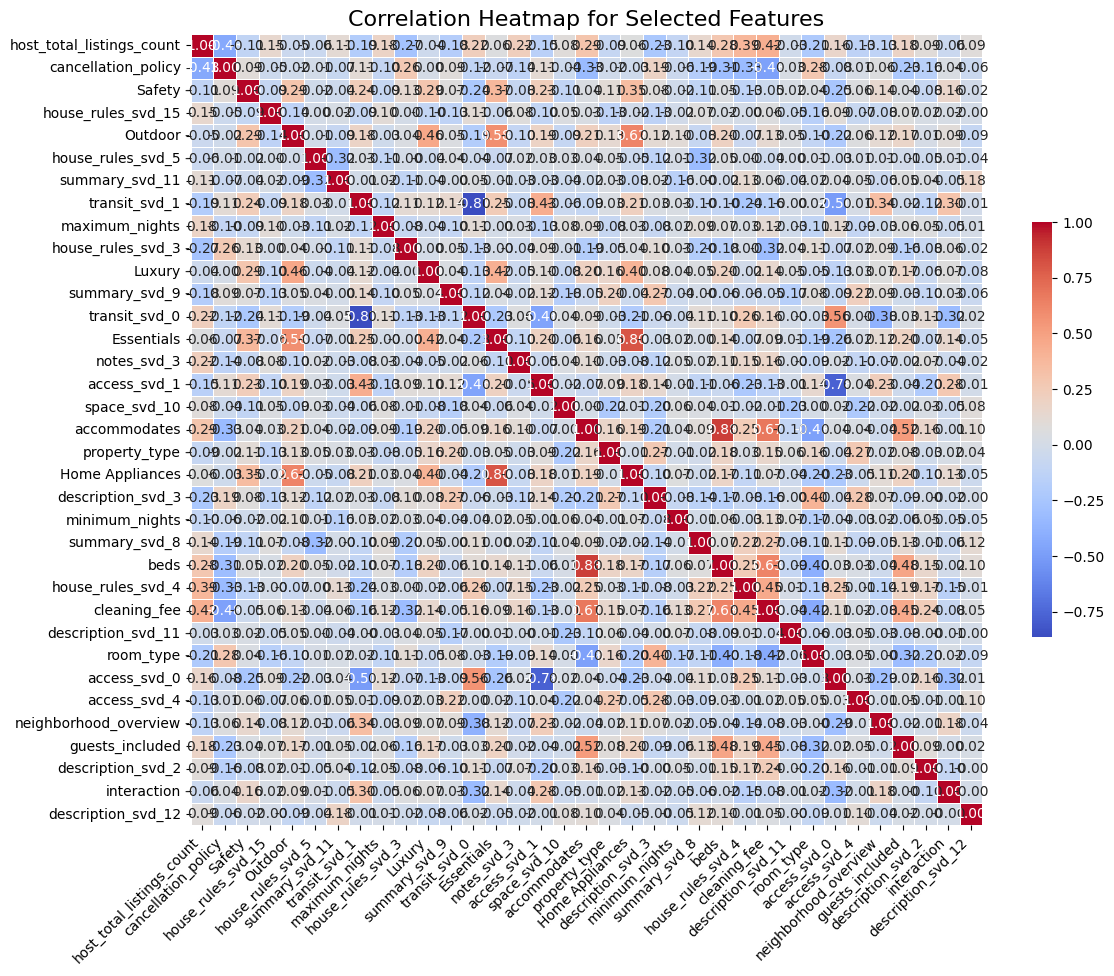

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_data = df[selected_features].corr()

plt.figure(figsize=(12, 10))

sns.heatmap(correlation_data,
            annot=True,
            cmap="coolwarm",
            fmt=".2f",
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .5})

plt.title("Correlation Heatmap for Selected Features", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()


Model Training and Selection

Splitting the data into features and target

In [ ]:
x=df[selected_features]
y= df['review_scores_rating']
 # Splitting the data into 80% training and 20% testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

Feature Scaling using Robust Scaler

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Metrics

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    metrics = {
        'R2 Score': r2_score(y_true, y_pred),
        'Mean Absolute Error (MAE)': mean_absolute_error(y_true, y_pred),
        'Mean Squared Error (MSE)': mse,
        'Root Mean Squared Error (RMSE)': np.sqrt(mse),
        'Mean Absolute Percentage Error (MAPE)': mean_absolute_percentage_error(y_true, y_pred)
    }
    return metrics


*#-* * * * * * * ------------------------- LINEAR MODELS------------------------#*

Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

linear_reg = LinearRegression()
cv_scores = cross_val_score(linear_reg, x, y, cv=5, scoring='r2', n_jobs=-1)
print("\nLINEAR REGRESSION MODEL: ")
print(f"Cross-Validation R2 Scores: {cv_scores}")
print(f"Average Cross-Validation R2 Score: {cv_scores.mean():.4f}")
linear_reg.fit(X_train, y_train)
train_r2 = linear_reg.score(X_train, y_train)
print(f"Training R2 Score: {train_r2:.4f}")
y_pred_linear = linear_reg.predict(X_test)
results = regression_metrics(y_test, y_pred_linear)
print("Test Set Metrics:\n")
for metric_name, value in results.items():
    print(f"{metric_name}: {value:.4f}")
print("\n")


LINEAR REGRESSION MODEL: 
Cross-Validation R2 Scores: [0.12288149 0.11025478 0.10255171 0.13394125 0.14455744]
Average Cross-Validation R2 Score: 0.1228
Training R2 Score: 0.1275
Test Set Metrics:

R2 Score: 0.1465
Mean Absolute Error (MAE): 3.1958
Mean Squared Error (MSE): 16.5829
Root Mean Squared Error (RMSE): 4.0722
Mean Absolute Percentage Error (MAPE): 0.0341




SVR

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid_svr = {
    'C': np.logspace(-1, 2, 5),
    'epsilon': np.linspace(0.01, 1, 5),
    'kernel': ['rbf']
}
svr = SVR()
grid_search_svr = GridSearchCV(estimator=svr, param_grid=param_grid_svr, cv=5, scoring='r2', n_jobs=-1)
grid_search_svr.fit(X_train, y_train)
best_params_svr = grid_search_svr.best_params_
print("SVR MODEL: ")
print(f"Best parameters (SVR): {best_params_svr}")
best_score_svr = grid_search_svr.best_score_
print(f"Best CV score (R²) (SVR): {best_score_svr:.4f}")
best_svr_model = grid_search_svr.best_estimator_
train_r2_svr = best_svr_model.score(X_train, y_train)
print(f"Training R² Score: {train_r2_svr:.4f}")
y_pred_svr = best_svr_model.predict(X_test)
results_svr = regression_metrics(y_test, y_pred_svr)
print("Test Set Metrics (SVR):\n")
for metric_name, value in results_svr.items():
    print(f"{metric_name}: {value:.4f}")
print("\n")

SVR MODEL: 
Best parameters (SVR): {'C': 3.1622776601683795, 'epsilon': 1.0, 'kernel': 'rbf'}
Best CV score (R²) (SVR): 0.0737
Training R² Score: 0.2166
Test Set Metrics (SVR):

R2 Score: 0.0849
Mean Absolute Error (MAE): 3.0440
Mean Squared Error (MSE): 17.7783
Root Mean Squared Error (RMSE): 4.2164
Mean Absolute Percentage Error (MAPE): 0.0329




Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge

param_grid_ridge = {
   'alpha': np.logspace(-3, 3, 10)
}
ridge = Ridge()
grid_search_ridge = GridSearchCV(estimator=ridge, param_grid=param_grid_ridge, cv=5, scoring='r2', n_jobs=-1)
grid_search_ridge.fit(X_train, y_train)
best_params_ridge = grid_search_ridge.best_params_
print("RIDGE REGRESSION MODEL: ")
print(f"Best parameters (Ridge): {best_params_ridge}")
best_score_ridge = grid_search_ridge.best_score_
print(f"Best CV score (R²) (Ridge): {best_score_ridge:.4f}")
best_ridge_model = grid_search_ridge.best_estimator_
train_r2_ridge = best_ridge_model.score(X_train, y_train)
print(f"Training R² Score: {train_r2_ridge:.4f}")
y_pred_ridge = best_ridge_model.predict(X_test)
results_ridge = regression_metrics(y_test, y_pred_ridge)
print("Test Set Metrics (Ridge):\n")
for metric_name, value in results_ridge.items():
    print(f"{metric_name}: {value:.4f}")
print("\n")

RIDGE REGRESSION MODEL: 
Best parameters (Ridge): {'alpha': 215.44346900318823}
Best CV score (R²) (Ridge): 0.1174
Training R² Score: 0.1271
Test Set Metrics (Ridge):

R2 Score: 0.1436
Mean Absolute Error (MAE): 3.2043
Mean Squared Error (MSE): 16.6375
Root Mean Squared Error (RMSE): 4.0789
Mean Absolute Percentage Error (MAPE): 0.0342




Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

param_grid_lasso = {
    'alpha': np.logspace(-6, -3, 10)
}
lasso = Lasso()
grid_search_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid_lasso, cv=5, scoring='r2', n_jobs=-1)
grid_search_lasso.fit(X_train, y_train)
best_params_lasso = grid_search_lasso.best_params_
print("LASSO REGRESSION MODEL: ")
print(f"Best parameters (Lasso): {best_params_lasso}")
best_score_lasso = grid_search_lasso.best_score_
print(f"Best CV score (R²) (Lasso): {best_score_lasso:.4f}")
best_lasso_model = grid_search_lasso.best_estimator_
train_r2 = best_lasso_model.score(X_train, y_train)
print(f"Training R² Score: {train_r2:.4f}")
y_pred_lasso = best_lasso_model.predict(X_test)
results_lasso = regression_metrics(y_test, y_pred_lasso)
print("Test Set Metrics (Lasso):\n")
for metric_name, value in results_lasso.items():
    print(f"{metric_name}: {value:.4f}")
print("\n")

LASSO REGRESSION MODEL: 
Best parameters (Lasso): {'alpha': 0.001}
Best CV score (R²) (Lasso): 0.1168
Training R² Score: 0.1275
Test Set Metrics (Lasso):

R2 Score: 0.1462
Mean Absolute Error (MAE): 3.1968
Mean Squared Error (MSE): 16.5880
Root Mean Squared Error (RMSE): 4.0728
Mean Absolute Percentage Error (MAPE): 0.0341




*<< Ensemble models >>***

Bagging models

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

param_grid_rf = {
   'n_estimators': [50, 100],
   'max_depth': [None, 10],
   'min_samples_split': [2, 5],
   'min_samples_leaf': [1, 2]
}
rf = RandomForestRegressor(random_state=0)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, scoring='r2', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_
print("RANDOM FOREST MODEL: ")
print(f"Best parameters (RandomForest): {best_params_rf}")
best_score_rf = grid_search_rf.best_score_
print(f"Best CV score (R²) (RandomForest): {best_score_rf:.4f}")
best_rf_model = grid_search_rf.best_estimator_
train_r2_rf = best_rf_model.score(X_train, y_train)
print(f"Training R² Score: {train_r2_rf:.4f}")
y_pred_rf = best_rf_model.predict(X_test)
results_rf = regression_metrics(y_test, y_pred_rf)
print("Test Set Metrics (RandomForest):\n")
for metric_name, value in results_rf.items():
    print(f"{metric_name}: {value:.4f}")
print("\n")

RANDOM FOREST MODEL: 
Best parameters (RandomForest): {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best CV score (R²) (RandomForest): 0.1169
Training R² Score: 0.4769
Test Set Metrics (RandomForest):

R2 Score: 0.1428
Mean Absolute Error (MAE): 3.1795
Mean Squared Error (MSE): 16.6530
Root Mean Squared Error (RMSE): 4.0808
Mean Absolute Percentage Error (MAPE): 0.0340




Decision tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
param_grid_dt = {
   'max_depth': [None, 10, 20],
   'min_samples_split': [2, 5],
   'min_samples_leaf': [1, 2]
}
dt = DecisionTreeRegressor(random_state=0)
grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=5, scoring='r2', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)
best_params_dt = grid_search_dt.best_params_
print("DESICION TREE MODEL: ")
print(f"Best parameters (DecisionTree): {best_params_dt}")
best_score_dt = grid_search_dt.best_score_
print(f"Best CV score (R²) (DecisionTree): {best_score_dt:.4f}")
best_dt_model = grid_search_dt.best_estimator_
train_r2_dt = best_dt_model.score(X_train, y_train)
print(f"Training R² Score: {train_r2_dt:.4f}")
y_pred_dt = best_dt_model.predict(X_test)
results_dt = regression_metrics(y_test, y_pred_dt)
print("Test Set Metrics (DecisionTree):\n")
for metric_name, value in results_dt.items():
    print(f"{metric_name}: {value:.4f}")

DESICION TREE MODEL: 
Best parameters (DecisionTree): {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best CV score (R²) (DecisionTree): -0.1688
Training R² Score: 0.4284
Test Set Metrics (DecisionTree):

R2 Score: -0.1849
Mean Absolute Error (MAE): 3.5947
Mean Squared Error (MSE): 23.0212
Root Mean Squared Error (RMSE): 4.7980
Mean Absolute Percentage Error (MAPE): 0.0384


XGBoost

In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=105,
    max_depth=3,
    learning_rate=0.1435307406386383,
    subsample=0.955315863949093,
    colsample_bytree=0.9788141815588388,
    random_state=0,
    verbosity=0
)
cv_scores_xgb = cross_val_score(xgb_model, x, y, cv=5, scoring='r2', n_jobs=-1)
print(f"Cross-Validation R² Scores: {cv_scores_xgb}")
print(f"Average Cross-Validation R² Score: {cv_scores_xgb.mean():.4f}")
xgb_model.fit(X_train, y_train)
train_r2_xgb = xgb_model.score(X_train, y_train)
print(f"Training R² Score: {train_r2_xgb:.4f}")
y_pred_xgb = xgb_model.predict(X_test)
results_xgb = regression_metrics(y_test, y_pred_xgb)
print("Test Set Metrics (XGBoost):")
for metric_name, value in results_xgb.items():
    print(f"{metric_name}: {value:.4f}")

print("\n")

Cross-Validation R² Scores: [0.14013852 0.12032221 0.12864808 0.13211795 0.16027015]
Average Cross-Validation R² Score: 0.1363
Training R² Score: 0.2845
Test Set Metrics (XGBoost):
R2 Score: 0.1634
Mean Absolute Error (MAE): 3.1298
Mean Squared Error (MSE): 16.2540
Root Mean Squared Error (RMSE): 4.0316
Mean Absolute Percentage Error (MAPE): 0.0334




Light gbm

In [ ]:
from lightgbm import LGBMRegressor

light_model = LGBMRegressor(
    n_estimators=1547,
    learning_rate=0.014286813901088678,
    max_depth=3,
    reg_lambda=35,
    subsample=0.8148197144286347,
    subsample_freq=5,
    random_state=0
)
cv_scores_light = cross_val_score(light_model, x, y, cv=5, scoring='r2', n_jobs=-1)
print(f"Cross-Validation R² Scores: {cv_scores_light}")
print(f"Average Cross-Validation R² Score: {cv_scores_light.mean():.4f}")
light_model.fit(X_train, y_train)
train_r2_light = light_model.score(X_train, y_train)
print(f"Training R² Score: {train_r2_light:.4f}")
y_pred_light = light_model.predict(X_test)
results_light = regression_metrics(y_test, y_pred_light)
print("Test Set Metrics (LightGBM):")
for metric_name, value in results_light.items():
    print(f"{metric_name}: {value:.4f}")

print("\n")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5554
[LightGBM] [Info] Number of data points in the train set: 6979, number of used features: 35
[LightGBM] [Info] Start training from score 95.885370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

< Stacking model>

In [ ]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor

lgb_model = LGBMRegressor(
    random_state=0,
    n_estimators=1534,
    learning_rate=0.010382774494101006,
    max_depth=3,
    reg_lambda=35,
    subsample=0.8148197144286347,
    subsample_freq=5
)
cat_model = CatBoostRegressor(
    verbose=0,
    random_state=0,
    depth=5,
    iterations=3234,
    learning_rate=0.009991409541444202,
    l2_leaf_reg=64,
    bagging_temperature=0.9446579587709355
)
meta_model = XGBRegressor(
    n_estimators=35,
    max_depth=3,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=0.8,
    random_state=0,
    verbosity=1
)


stacked_model3 = StackingRegressor(
    estimators=[
        ('lightgbm', lgb_model),
        ('catboost', cat_model)
    ],
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=True
)

stacked_model3.fit(X_train, y_train)
y_pred_stack3 = stacked_model3.predict(X_test)
train_stack = stacked_model3.score(X_train, y_train)
print(f"Training R² Score: {train_stack:.4f}")
results_stacking = regression_metrics(y_test,y_pred_stack3)
print("Test Set Metrics (Stacking):")
for metric_name, value in results_stacking.items():
    print(f"{metric_name}: {value:.4f}")
print("\n")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-c

Model Accuracy Comparison

In [ ]:
results = {
    'Linear Regression': regression_metrics(y_test, y_pred_linear),
    'Lasso Regression': regression_metrics(y_test, y_pred_lasso),
    'Ridge Regression': regression_metrics(y_test, y_pred_ridge),
    # 'ElasticNet': regression_metrics(y_test, y_pred_elasticnet),
    'SVR': regression_metrics(y_test, y_pred_svr),
    'Random Forest': regression_metrics(y_test, y_pred_rf),
    'Decision Tree': regression_metrics(y_test, y_pred_dt),
    'XGBoost': regression_metrics(y_test, y_pred_xgb),
    # 'CatBoost': regression_metrics(y_test, y_pred_cat),
    'LightGBM': regression_metrics(y_test, y_pred_light),
    'Stacking': regression_metrics(y_test, y_pred_stack3)
}

R2 SCORE

In [ ]:
r2_scores = {model: round(results[model]['R2 Score'], 4) for model in results}
r2_table = pd.DataFrame(list(r2_scores.items()), columns=['Model', 'R² Score'])
print("R² Table:")
print(r2_table)

R² Table:
               Model  R² Score
0  Linear Regression    0.1465
1   Lasso Regression    0.1462
2   Ridge Regression    0.1436
3                SVR    0.0849
4      Random Forest    0.1428
5      Decision Tree   -0.1849
6            XGBoost    0.1634
7           LightGBM    0.1619
8           Stacking    0.1640


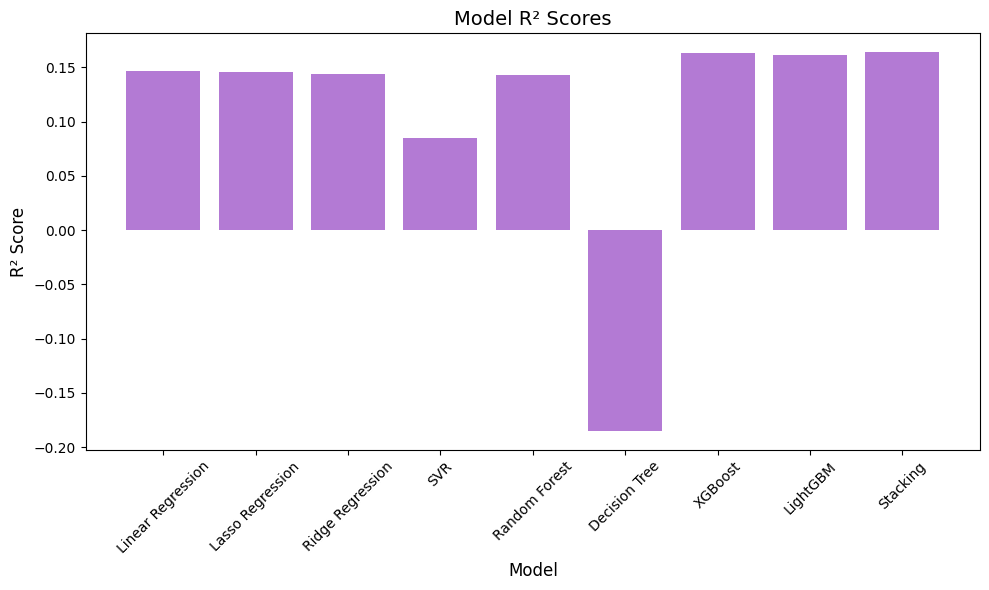

In [ ]:
import matplotlib.pyplot as plt

# الرسم الأول: R² Scores
plt.figure(figsize=(10, 6))
plt.bar(r2_scores.keys(), r2_scores.values(), color="#B37AD4")
plt.title('Model R² Scores', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


MSE

In [ ]:
mse_scores = {model: round(results[model]['Mean Squared Error (MSE)'], 4) for model in results}
mse_table = pd.DataFrame(list(mse_scores.items()), columns=['Model', 'Mean Squared Error (MSE)'])
print("MSE Table:")
print(mse_table)

MSE Table:
               Model  Mean Squared Error (MSE)
0  Linear Regression                   16.5829
1   Lasso Regression                   16.5880
2   Ridge Regression                   16.6375
3                SVR                   17.7783
4      Random Forest                   16.6530
5      Decision Tree                   23.0212
6            XGBoost                   16.2540
7           LightGBM                   16.2824
8           Stacking                   16.2413


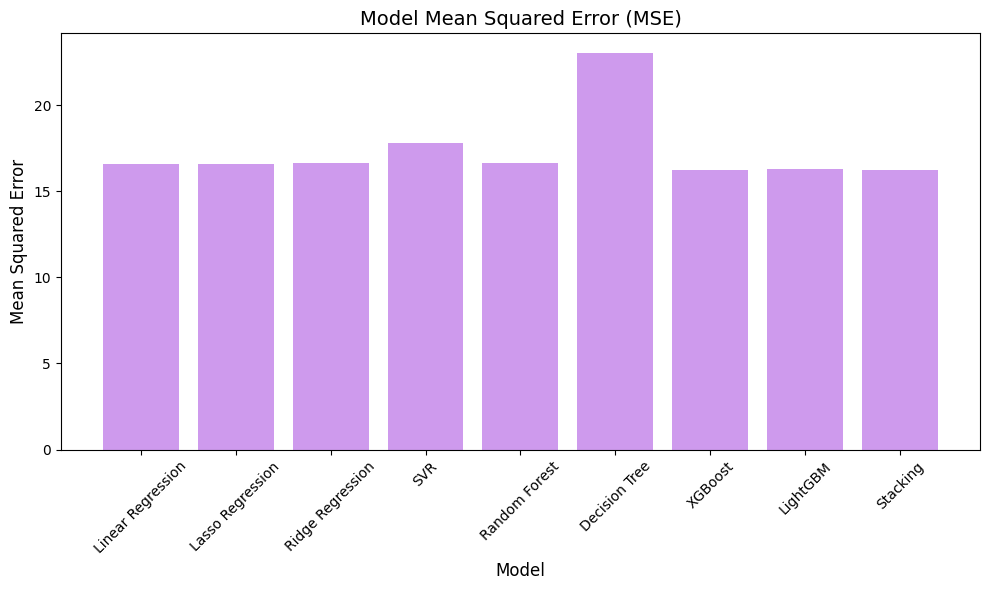

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(mse_scores.keys(), mse_scores.values(), color="#CE9AED")
plt.title('Model Mean Squared Error (MSE)', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()